In [2]:
%matplotlib inline 
import requests 
import numpy as np
import pandas as pd # pandas
import missingno as msno
import matplotlib.pyplot as plt # module for plotting 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import datetime as dt # module for manipulating dates and times
from scipy import stats
from sklearn.cluster import KMeans
from pandas import Series
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing

In [3]:
df_orig = pd.read_excel('C:/PennState/DAAN888/DataKwip/ModifiedAHUData/Anomaly n feature selection/test1.xlsx', skip_blank_lines=True, delim_whitespace=True)

In [4]:
df_orig = df_orig.set_index('Timestamp')


In [5]:
df_orig.Econ_Pos.skew()

3.340699697907706

#### Transform Economizer Position and replace it in the AHU dataframe
#### The domain for log is strictly greater than 0. As x approaches 0, y approaches negative infinity. In other words, 0 is excluded from the domain.Many of my data points are 0 because many economizer values are 0. For a quick fix, we added 1 to each data point. This works well since the log of 1 is 0. Furthermore, the same spread is retained since all points are increased by 1.

In [6]:
#Log Function + 1
df_orig['log_econ_pos'] = np.log(df_orig.Econ_Pos+1)
df_new = df_orig.drop(['Econ_Pos'], axis=1)
df_new.head()

CompAmps  Dat_SetPt  Discharge_Temp  DuctStatic_SetPt  \
Timestamp                                                                    
2016-08-01 00:00:00         0       55.0            75.7               1.0   
2016-08-01 01:00:00         0       55.0            75.4               1.0   
2016-08-01 02:00:00         0       55.0            77.0               1.0   
2016-08-01 03:00:00        60       55.0            54.0               1.0   
2016-08-01 04:00:00        47       55.0            59.7               1.0   

                     DuctStatic  East_Temp  Fan_Hz_call  Mixed_Temp  \
Timestamp                                                             
2016-08-01 00:00:00        0.91       73.2           20        77.7   
2016-08-01 01:00:00        0.08       77.6           20        77.6   
2016-08-01 02:00:00        0.08       78.5           20        77.6   
2016-08-01 03:00:00        1.00       70.6           20        77.6   
2016-08-01 04:00:00        1.06       71.2           20        77.9   

                     NorthTemp  Reset_Sensor      ...       Outside_Air_Temp  \
Timestamp                                         ...                          
2016-08-01 00:00:00       77.5          74.2      ...                   78.2   
2016-08-01 01:00:00       77.4          77.7      ...                   77.3   
2016-08-01 02:00:00       77.4          78.7      ...                   76.4   
2016-08-01 03:00:00       77.4          73.4      ...                   75.6   
2016-08-01 04:00:00       77.3          73.3      ...                   75.1   

                     Outside_Rel_Humidity  CompRelayStatus  Loader2Status  \
Timestamp                                                                   
2016-08-01 00:00:00                 100.0                0              0   
2016-08-01 01:00:00                 100.0                0              0   
2016-08-01 02:00:00                 100.0                0              0   
2016-08-01 03:00:00                 100.0                0              0   
2016-08-01 04:00:00                 100.0                0              0   

                     SupplyFanStatus  VAVEnableRelayStatus  \
Timestamp                                                    
2016-08-01 00:00:00                1                     1   
2016-08-01 01:00:00                0                     0   
2016-08-01 02:00:00                0                     0   
2016-08-01 03:00:00                1                     1   
2016-08-01 04:00:00                1                     1   

                     VAVHeatEnableStatus  Loader1sTATUS  UnoccupiedLimit  \
Timestamp                                                                  
2016-08-01 00:00:00                    0              0                0   
2016-08-01 01:00:00                    0              0                0   
2016-08-01 02:00:00                    0              0                0   
2016-08-01 03:00:00                    0              0                0   
2016-08-01 04:00:00                    0              0                0   

                     log_econ_pos  
Timestamp                          
2016-08-01 00:00:00      1.791759  
2016-08-01 01:00:00      0.000000  
2016-08-01 02:00:00      0.000000  
2016-08-01 03:00:00      0.000000  
2016-08-01 04:00:00      0.000000  

[5 rows x 24 columns]

In [7]:
df_orig['log_econ_pos'].skew()

1.2983724369978515

In [8]:
df_orig['log_econ_pos'].describe()

count    8628.000000
mean        0.939774
std         1.349980
min         0.000000
25%         0.000000
50%         0.000000
75%         1.791759
max         4.615121
Name: log_econ_pos, dtype: float64

#### We also tried cuberoot transformation for econ pos. The skenwess dcreased maximum using log transformation
#### cube root
##### df_orig['econ_cube_root'] = df1.Econ_Pos**(1/3) #### 1.3893412297520562

#### Create new columns for DayOfTheWeek ( 0-6), Weekend/Weekday(0/1), OpHours/Non Op Hours(1/0)

In [10]:
df_new = df_new.reset_index()
df_new['hours'] = df_new['Timestamp'].dt.hour

#df_new['daylight'] = ((df_new['hours'] >= 18) & (df_new['hours'] <= 6)).astype(int)
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df_new['DayOfTheWeek'] = df_new['Timestamp'].dt.dayofweek
df_new['DayOfWeek'] = np.where((df_new['DayOfTheWeek'] < 5), "Weekday","Weekend")
df_new['OpHours'] = np.where(( ((df_new['DayOfTheWeek']>4) & (df_new['hours'] > 18)) | ((df_new['DayOfTheWeek']>4) & (df_new['hours'] < 6))| ((df_new['DayOfTheWeek']>4) & (df_new['hours'] < 18)) | ((df_new['DayOfTheWeek']>4) & (df_new['hours'] > 6))| (df_new['hours'] > 18) | (df_new['hours'] < 6 )  ), "Non-Operating Hours", "Operating Hours")
#df_new['WeekDay'] = (df_new['DayOfTheWeek'] < 5).astype(int)

df_new.to_excel('WeekdayCheck_119.xlsx')

#### Load cleaned data with Weekday/Weekend, DayOfTheWeek and OperatingHour information

In [356]:
df_orig = pd.read_excel('C:/PennState/DAAN888/DataKwip/ModifiedAHUData/Anomaly n feature selection/WeekdayLabelled_AHUData.xlsx', skip_blank_lines=True, delim_whitespace=True)

In [357]:
df_orig.head()

Timestamp  CompAmps  Dat_SetPt  Discharge_Temp  DuctStatic_SetPt  \
0 2016-08-01 00:00:00         0       55.0            75.7               1.0   
1 2016-08-01 01:00:00         0       55.0            75.4               1.0   
2 2016-08-01 02:00:00         0       55.0            77.0               1.0   
3 2016-08-01 03:00:00        60       55.0            54.0               1.0   
4 2016-08-01 04:00:00        47       55.0            59.7               1.0   

   DuctStatic  East_Temp  Fan_Hz_call  Mixed_Temp  NorthTemp  \
0        0.91       73.2           20        77.7       77.5   
1        0.08       77.6           20        77.6       77.4   
2        0.08       78.5           20        77.6       77.4   
3        1.00       70.6           20        77.6       77.4   
4        1.06       71.2           20        77.9       77.3   

          ...           Loader2Status  SupplyFanStatus  VAVEnableRelayStatus  \
0         ...                       0                1                     1   
1         ...                       0                0                     0   
2         ...                       0                0                     0   
3         ...                       0                1                     1   
4         ...                       0                1                     1   

   VAVHeatEnableStatus  Loader1sTATUS  UnoccupiedLimit  log_econ_pos  \
0                    0              0                0      1.791759   
1                    0              0                0      0.000000   
2                    0              0                0      0.000000   
3                    0              0                0      0.000000   
4                    0              0                0      0.000000   

   DayOfTheWeek  WeekDay              OpHours  
0             0        1  Non-Operating Hours  
1             0        1  Non-Operating Hours  
2             0        1  Non-Operating Hours  
3             0        1  Non-Operating Hours  
4             0        1  Non-Operating Hours  

[5 rows x 28 columns]

In [358]:
len(df_orig)

8628

In [359]:
columns = ['OpHours']
for col in columns:
    df_orig[col].replace({'Non-Operating Hours':'N', 'Operating Hours':'Y'}, inplace=True)
    df_orig[col].replace(to_replace=dict(Y=1, N=0), inplace=True)

In [360]:
df_orig = df_orig.set_index(['Timestamp'])

#### Silhouette plot

In [16]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
import matplotlib.cm as cm
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [17]:
range_n_clusters = [5, 6, 7, 8 , 9 ,10, 11]

Automatically created module for IPython interactive environment
For n_clusters = 5 The average silhouette_score is : 0.32504369826598
For n_clusters = 6 The average silhouette_score is : 0.31702812388234325
For n_clusters = 7 The average silhouette_score is : 0.3288944935084256
For n_clusters = 8 The average silhouette_score is : 0.31386037665897815
For n_clusters = 9 The average silhouette_score is : 0.30233565347163865
For n_clusters = 10 The average silhouette_score is : 0.319100844016252
For n_clusters = 11 The average silhouette_score is : 0.30193943765201786


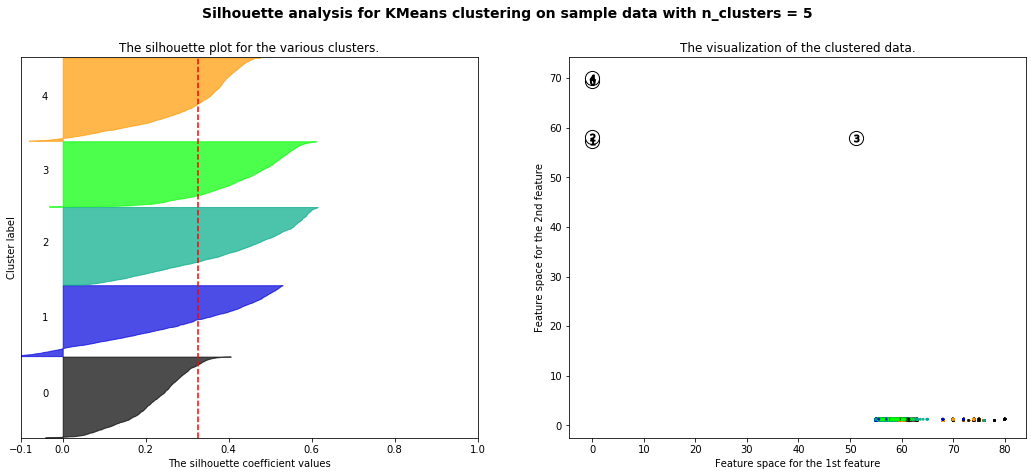

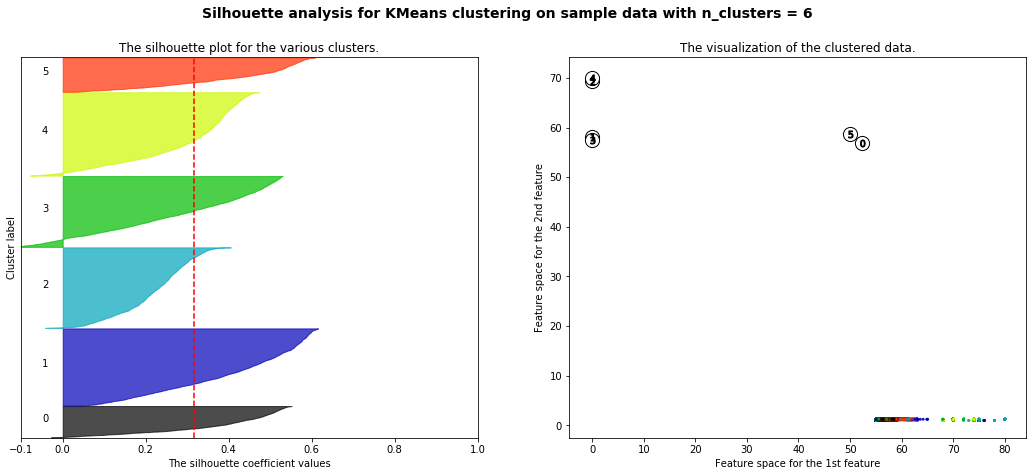

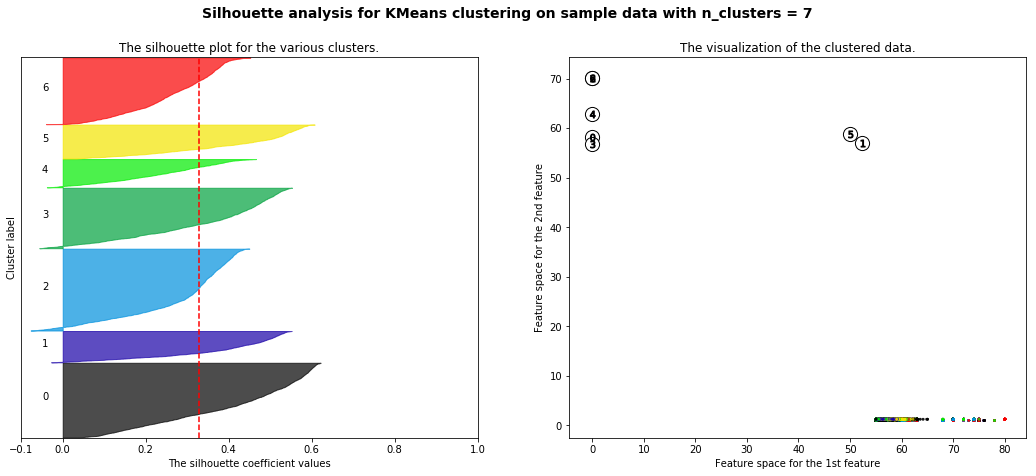

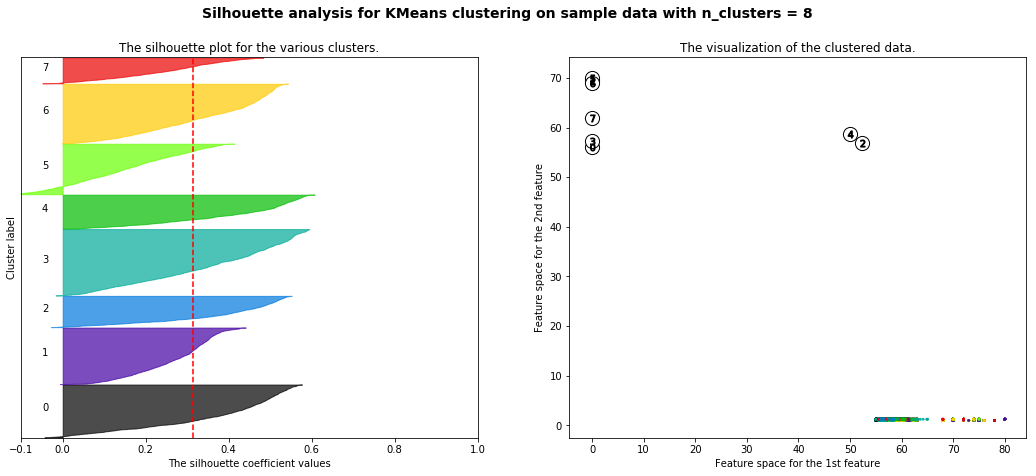

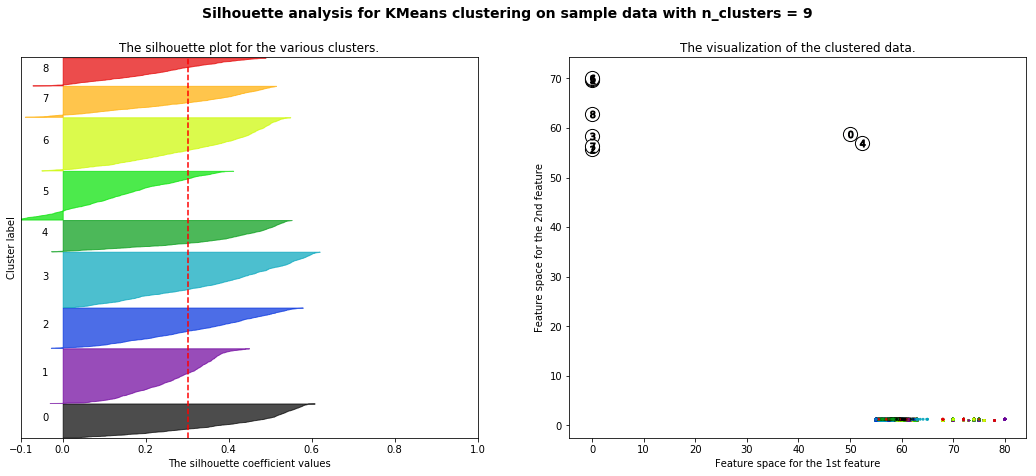

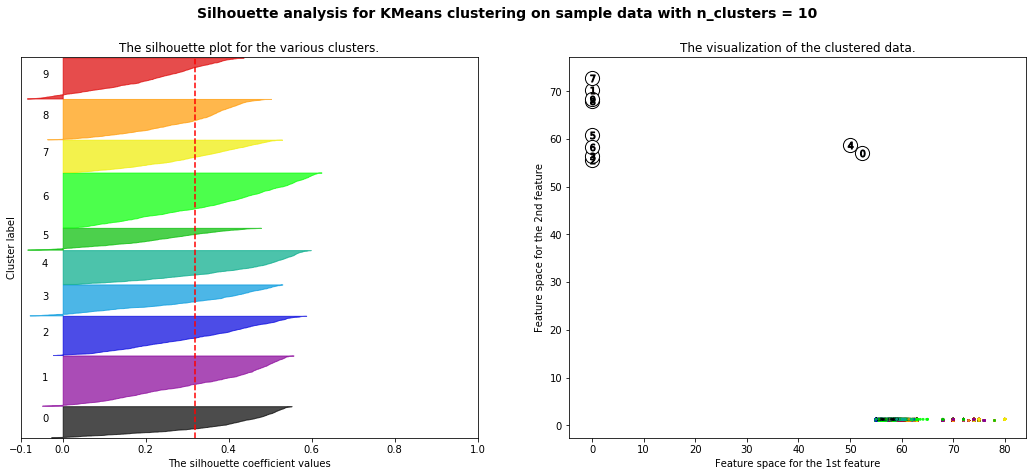

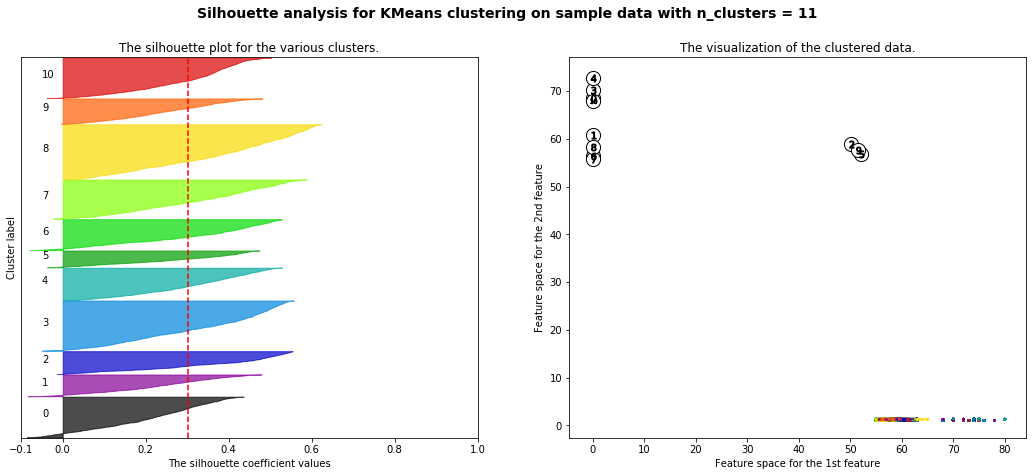

In [18]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_orig) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_orig)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_orig, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_orig, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(df_orig.iloc[:, 1], df_orig.iloc[:, 3], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

#### Create elbow plot to determine appropriate number of K clusters using K-means
#### We will be using 9 clusters as the elbow plot shows an insignificant decline in inertia beyond 9 clusters

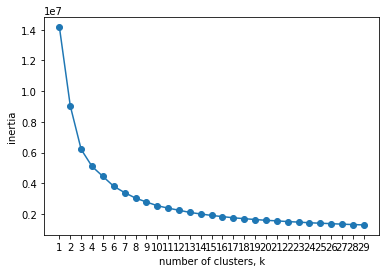

In [21]:
#df_orig = df_orig.drop(columns="anomalyIF")
df_Elbow = df_orig
ks = range(1, 30)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    # Fit model to samples
    model.fit(df_Elbow)
     # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

#### Replace String text for Operating and Non-Operating Hours to binary values (1/0)

#### Set Timestamp as Index of the dataframe

#### Run K-means cluster on the dataframe using 9 clusters as obtained from the Elbow plot

In [362]:
df_KMeans_9 = df_orig
df1 = np.array(df_KMeans_9)

model = KMeans(n_clusters=9)
model.fit(df1)
y_kmeans = model.predict(df1)
len(y_kmeans)

8628

#### Run K-means cluster on the dataframe using 7 clusters as obtained from Silhouette coeff

#### New column ClusterLabels is added to the dataframe with cluster values 0-8

In [363]:
df_KMeans_9['ClusterLabels'] = Series(y_kmeans,index=df_KMeans_9.index)
df_KMeans_9.ClusterLabels.unique()

array([4, 3, 0, 5, 8, 7, 2, 6, 1], dtype=int64)

In [26]:
df_KMeans_9.to_excel('AHUData_Labelled_9Clusters.xlsx')

In [364]:
df_KMeans_9.head()

CompAmps  Dat_SetPt  Discharge_Temp  DuctStatic_SetPt  \
Timestamp                                                                    
2016-08-01 00:00:00         0       55.0            75.7               1.0   
2016-08-01 01:00:00         0       55.0            75.4               1.0   
2016-08-01 02:00:00         0       55.0            77.0               1.0   
2016-08-01 03:00:00        60       55.0            54.0               1.0   
2016-08-01 04:00:00        47       55.0            59.7               1.0   

                     DuctStatic  East_Temp  Fan_Hz_call  Mixed_Temp  \
Timestamp                                                             
2016-08-01 00:00:00        0.91       73.2           20        77.7   
2016-08-01 01:00:00        0.08       77.6           20        77.6   
2016-08-01 02:00:00        0.08       78.5           20        77.6   
2016-08-01 03:00:00        1.00       70.6           20        77.6   
2016-08-01 04:00:00        1.06       71.2           20        77.9   

                     NorthTemp  Reset_Sensor      ...        SupplyFanStatus  \
Timestamp                                         ...                          
2016-08-01 00:00:00       77.5          74.2      ...                      1   
2016-08-01 01:00:00       77.4          77.7      ...                      0   
2016-08-01 02:00:00       77.4          78.7      ...                      0   
2016-08-01 03:00:00       77.4          73.4      ...                      1   
2016-08-01 04:00:00       77.3          73.3      ...                      1   

                     VAVEnableRelayStatus  VAVHeatEnableStatus  Loader1sTATUS  \
Timestamp                                                                       
2016-08-01 00:00:00                     1                    0              0   
2016-08-01 01:00:00                     0                    0              0   
2016-08-01 02:00:00                     0                    0              0   
2016-08-01 03:00:00                     1                    0              0   
2016-08-01 04:00:00                     1                    0              0   

                     UnoccupiedLimit  log_econ_pos  DayOfTheWeek  WeekDay  \
Timestamp                                                                   
2016-08-01 00:00:00                0      1.791759             0        1   
2016-08-01 01:00:00                0      0.000000             0        1   
2016-08-01 02:00:00                0      0.000000             0        1   
2016-08-01 03:00:00                0      0.000000             0        1   
2016-08-01 04:00:00                0      0.000000             0        1   

                     OpHours  ClusterLabels  
Timestamp                                    
2016-08-01 00:00:00        0              4  
2016-08-01 01:00:00        0              4  
2016-08-01 02:00:00        0              4  
2016-08-01 03:00:00        0              3  
2016-08-01 04:00:00        0              3  

[5 rows x 28 columns]

In [365]:
df_KMeans_9['ClusterLabels'].value_counts()

4    1276
7    1254
6    1209
1    1116
8     920
3     778
2     725
0     717
5     633
Name: ClusterLabels, dtype: int64

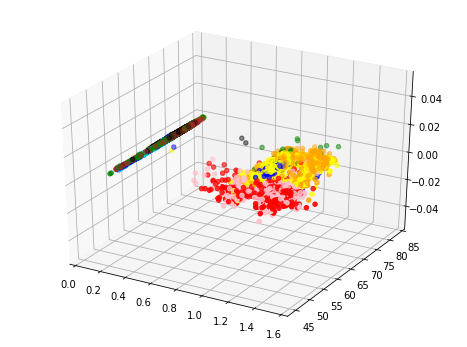

In [366]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black',5:'orange', 6:'cyan', 7:'yellow', 8:'brown'}
ax.scatter(list(df_KMeans_9.DuctStatic.values),list(df_KMeans_9.Discharge_Temp.values), c=df_KMeans_9['ClusterLabels'].apply(lambda x: colors[x]))
#ax.scatter(list(df_IF.CompAmps.values),list(df_IF.Discharge_Temp.values), c=df_IF['ClusterLabels'].apply(lambda x: colors[x]))
plt.show()

#### Visualization of 9 clusters in a scatter plot of Ductstatic  and Discharge Temperature

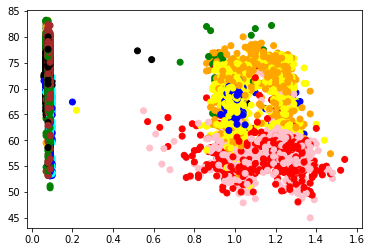

In [367]:
fig, ax = plt.subplots()
#df_KMeans_5 = df_KMeans_5.drop(columns= ['index'])
#df_IF = df_IF.reset_index()
#df_KMeans_5
#df_KMeans_5 = df_KMeans_5.set_index(['Timestamp'])
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black',5:'orange', 6:'cyan', 7:'yellow', 8:'brown'}
ax.scatter(list(df_KMeans_9.DuctStatic.values),list(df_KMeans_9.Discharge_Temp.values), c=df_KMeans_9['ClusterLabels'].apply(lambda x: colors[x]))
#ax.scatter(list(df_KMeans_9.CompAmps.values),list(df_KMeans_9.Discharge_Temp.values), c=df_KMeans_9['ClusterLabels'].apply(lambda x: colors[x]))
plt.show()

In [225]:
# return Series of distance between each point and his distance with the closest centroid
def PointBasedDistance(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

[-14163552.122061655, -9035391.724866778, -6206838.400815285, -5096625.090684825, -4446775.893433267, -3800002.6798014077, -3382781.4705060357, -3035077.892010556, -2779606.5040316787, -2538239.318822953, -2378509.330345212, -2237679.1590836057, -2100644.705451907, -2006312.8779015446, -1903196.1446182597, -1826180.291242275, -1749675.2417266658, -1691362.3094532131, -1638926.8298706939]


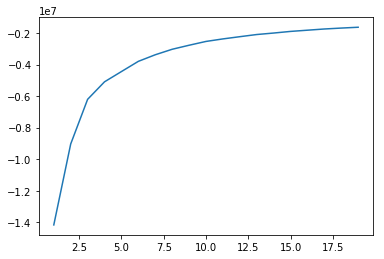

6    1260
0    1154
3     936
9     927
2     901
5     778
4     743
1     717
7     711
8     501
Name: cluster, dtype: int64

In [369]:
df_3 = df_orig
df_3 = df_3.reset_index()
df_3 = df_orig.drop('ClusterLabels', axis =1)
#df_3 = df_3.drop('Timestamp', axis =1)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(df_3) for i in n_cluster]
scores = [kmeans[i].score(df_3) for i in range(len(kmeans))]
print(scores)
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()
df_3['cluster'] = kmeans[9].predict(df_3)
df_3['cluster'].value_counts()

In [223]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
import sys
contamination_factor = 0.01
#df_3 = df_3.reset_index()
#df_5 = df_5.reset_index()
df_5 = df_5.drop('Timestamp', axis =1)
distance = PointBasedDistance(df_5, kmeans[7])
number_of_outliers = int(contamination_factor*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df_5['anomalyKMeans'] = (distance >= threshold).astype(int)
df_5.to_excel('KmeansCluster_Anomaly_3.xlsx')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [84]:
df_1['cluster'] = kmeans[9].predict(df_1)
df_1['cluster'].value_counts()

8    1260
3    1151
7     936
4     926
1     904
2     778
9     745
0     717
6     711
5     500
Name: cluster, dtype: int64

#### Run Isolation Forest for anomaly detection using contamination factor 0.01 with 9 clusters which returns 87outliers

In [371]:
#columns = [ 'CompAmps','Dat_SetPt','Discharge_Temp','DuctStatic_SetPt','DuctStatic', 'East_Temp','Fan_Hz_call','Mixed_Temp','NorthTemp','Reset_Sensor','Return_temp','South_Temp','Space_Temp','West_Temp','Outside_Air_Temp','Outside_Rel_Humidity','CompRelayStatus','Loader2Status','SupplyFanStatus','VAVEnableRelayStatus','VAVHeatEnableStatus','Loader1sTATUS','UnoccupiedLimit','log_econ_pos','DayOfTheWeek','WeekDay','OpHours']
clf = IsolationForest(random_state = 42,  max_samples=8628,contamination=0.01)
df_IF = df_KMeans_9
clf.fit(df_IF)
predict  = pd.Series(clf.predict(df_IF))
predict = predict.map({1:0, -1:1})
print(predict.value_counts())
predict.count()
predict

0    8541
1      87
dtype: int64


0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
8598    0
8599    0
8600    0
8601    0
8602    0
8603    0
8604    0
8605    0
8606    0
8607    1
8608    0
8609    0
8610    0
8611    0
8612    0
8613    0
8614    0
8615    0
8616    0
8617    0
8618    0
8619    0
8620    0
8621    0
8622    0
8623    0
8624    0
8625    0
8626    0
8627    0
Length: 8628, dtype: int64

In [449]:
df_IF['anomaly'] = predict.values

In [450]:
df_IF.head()

CompAmps  Dat_SetPt  Discharge_Temp  DuctStatic_SetPt  \
Timestamp                                                                    
2016-08-01 00:00:00         0       55.0            75.7               1.0   
2016-08-01 01:00:00         0       55.0            75.4               1.0   
2016-08-01 02:00:00         0       55.0            77.0               1.0   
2016-08-01 03:00:00        60       55.0            54.0               1.0   
2016-08-01 04:00:00        47       55.0            59.7               1.0   

                     DuctStatic  East_Temp  Fan_Hz_call  Mixed_Temp  \
Timestamp                                                             
2016-08-01 00:00:00        0.91       73.2           20        77.7   
2016-08-01 01:00:00        0.08       77.6           20        77.6   
2016-08-01 02:00:00        0.08       78.5           20        77.6   
2016-08-01 03:00:00        1.00       70.6           20        77.6   
2016-08-01 04:00:00        1.06       71.2           20        77.9   

                     NorthTemp  Reset_Sensor   ...     VAVEnableRelayStatus  \
Timestamp                                      ...                            
2016-08-01 00:00:00       77.5          74.2   ...                        1   
2016-08-01 01:00:00       77.4          77.7   ...                        0   
2016-08-01 02:00:00       77.4          78.7   ...                        0   
2016-08-01 03:00:00       77.4          73.4   ...                        1   
2016-08-01 04:00:00       77.3          73.3   ...                        1   

                     VAVHeatEnableStatus  Loader1sTATUS  UnoccupiedLimit  \
Timestamp                                                                  
2016-08-01 00:00:00                    0              0                0   
2016-08-01 01:00:00                    0              0                0   
2016-08-01 02:00:00                    0              0                0   
2016-08-01 03:00:00                    0              0                0   
2016-08-01 04:00:00                    0              0                0   

                     log_econ_pos  DayOfTheWeek  WeekDay  OpHours  \
Timestamp                                                           
2016-08-01 00:00:00      1.791759             0        1        0   
2016-08-01 01:00:00      0.000000             0        1        0   
2016-08-01 02:00:00      0.000000             0        1        0   
2016-08-01 03:00:00      0.000000             0        1        0   
2016-08-01 04:00:00      0.000000             0        1        0   

                     ClusterLabels  anomaly  
Timestamp                                    
2016-08-01 00:00:00              4        0  
2016-08-01 01:00:00              4        0  
2016-08-01 02:00:00              4        0  
2016-08-01 03:00:00              3        0  
2016-08-01 04:00:00              3        0  

[5 rows x 29 columns]

In [451]:
df_IF.to_excel('AHUData_Weekday_9Cluster_Anomaly_Final.xlsx')

In [459]:
centers = model.cluster_centers_
centers

array([[ 5.23570432e+01,  5.69764296e+01,  5.68504881e+01,
         1.13040446e+00,  1.11891213e+00,  7.13693166e+01,
         5.41548117e+01,  7.52170153e+01,  7.54132497e+01,
         7.41895397e+01,  7.39602510e+01,  7.23880056e+01,
         7.40384937e+01,  7.70800558e+01,  8.45174338e+01,
         4.35186890e+01,  5.53695955e-01,  2.23152022e-02,
         1.00000000e+00,  1.00000000e+00,  4.18410042e-03,
         2.99860530e-01,  4.18410042e-02,  2.27946652e+00,
         2.11157601e+00,  9.38633194e-01,  8.96792190e-01],
       [ 1.31450406e-13,  6.97549283e+01,  6.62609319e+01,
         1.08624552e+00,  3.14605735e-01,  7.06038530e+01,
         2.53844086e+01,  6.65828853e+01,  7.03124552e+01,
         7.09200717e+01,  6.51902330e+01,  7.22894265e+01,
         7.08805556e+01,  7.06423835e+01,  4.31511649e+01,
         6.67772401e+01,  1.42941214e-15,  3.12250226e-17,
         4.37275986e-01,  2.33870968e-01,  2.33870968e-01,
        -5.89805982e-16, -3.64291930e-17,  4.17103860e-

In [387]:
model.cluster_centers_.shape

(9, 27)

In [417]:
df_clus0 = pd.DataFrame({'Timestamp':[0],'CompAmps':[0.00],'Dat_SetPt':[70.07],'Discharge_Temp':[67.41],'DuctStatic_SetPt':[1.06],'DuctStatic':[0.09],
                          'East_Temp':[70.70],'Fan_Hz_call':[20.00],'Mixed_Temp':[67.38],'NorthTemp':[69.95],'Reset_Sensor':[70.35],'Return_temp':[66.60],
                          'South_Temp':[72.20],'Space_Temp':[70.42],'West_Temp':[69.03],'Outside_Air_Temp':[45.83],'Outside_Rel_Humidity':[93.20],
                          'CompRelayStatus':[0.00],'Loader2Status':[0.00],'SupplyFanStatus':[0.26],'VAVEnableRelayStatus':[0.00],'VAVHeatEnableStatus':[0.00],
                          'Loader1sTATUS':[0.00],'UnoccupiedLimit':[0.00],'log_econ_pos':[0.33],'DayOfTheWeek':[3.60],'WeekDay':[0.55],'OpHours':[0.06],'ClusterLabels':[0]})
df_clus0 = df_clus0.set_index('Timestamp')
m_predict = pd.Series(clf.predict(df_clus0))
#m_predict = m_predict.map({1:0, -1:1})
m_predict

0    1
dtype: int32

In [375]:
df_clus1 = pd.DataFrame({'Timestamp':[0],'CompAmps':[0.00],'Dat_SetPt':[56.34],'Discharge_Temp':[73.30],'DuctStatic_SetPt':[1.13],'DuctStatic':[0.12],
                          'East_Temp':[76.10],'Fan_Hz_call':[21.47],'Mixed_Temp':[76.39],'NorthTemp':[76.29],'Reset_Sensor':[76.74],'Return_temp':[75.82],
                          'South_Temp':[75.96],'Space_Temp':[76.80],'West_Temp':[78.90],'Outside_Air_Temp':[78.61],'Outside_Rel_Humidity':[38.75],
                          'CompRelayStatus':[0.00],'Loader2Status':[0.00],'SupplyFanStatus':[0.06],'VAVEnableRelayStatus':[0.04],'VAVHeatEnableStatus':[0.00],
                          'Loader1sTATUS':[0.00],'UnoccupiedLimit':[0.00],'log_econ_pos':[0.14],'DayOfTheWeek':[3.62],'WeekDay':[0.51],'OpHours':[0.10],'ClusterLabels':[1]})
df_clus1 = df_clus1.set_index('Timestamp')
m_predict = pd.Series(clf.predict(df_clus1))
m_predict = m_predict.map({1:0, -1:1})
m_predict

0    0
dtype: int64

In [376]:
df_clus2 = pd.DataFrame({'Timestamp':[0],'CompAmps':[50.04],'Dat_SetPt':[58.72],'Discharge_Temp':[57.46],'DuctStatic_SetPt':[1.13],'DuctStatic':[1.13],
                          'East_Temp':[71.58],'Fan_Hz_call':[53.06],'Mixed_Temp':[74.43],'NorthTemp':[75.25],'Reset_Sensor':[73.75],'Return_temp':[73.29],
                          'South_Temp':[72.19],'Space_Temp':[73.70],'West_Temp':[75.93],'Outside_Air_Temp':[74.97],'Outside_Rel_Humidity':[83.91],
                          'CompRelayStatus':[0.63],'Loader2Status':[0.01],'SupplyFanStatus':[0.99],'VAVEnableRelayStatus':[1.00],'VAVHeatEnableStatus':[0.02],
                          'Loader1sTATUS':[0.15],'UnoccupiedLimit':[0.01],'log_econ_pos':[1.69],'DayOfTheWeek':[2.13],'WeekDay':[0.97],'OpHours':[0.79],'ClusterLabels':[2]})
df_clus2 = df_clus2.set_index('Timestamp')
m_predict = pd.Series(clf.predict(df_clus2))
m_predict = m_predict.map({1:0, -1:1})
m_predict

0    0
dtype: int64

In [377]:
#Non Anomalous Centroid
df_clus3 = pd.DataFrame({'Timestamp':[0],'CompAmps':[0.00],'Dat_SetPt':[55.85],'Discharge_Temp':[75.18],'DuctStatic_SetPt':[1.17],'DuctStatic':[0.08],
                          'East_Temp':[77.05],'Fan_Hz_call':[20.04],'Mixed_Temp':[77.24],'NorthTemp':[77.08],'Reset_Sensor':[77.26],'Return_temp':[76.65],
                          'South_Temp':[76.57],'Space_Temp':[77.40],'West_Temp':[78.96],'Outside_Air_Temp':[76.74],'Outside_Rel_Humidity':[69.39],
                          'CompRelayStatus':[0.00],'Loader2Status':[0.00],'SupplyFanStatus':[0.01],'VAVEnableRelayStatus':[0.00],'VAVHeatEnableStatus':[0.00],
                          'Loader1sTATUS':[0.00],'UnoccupiedLimit':[0.00],'log_econ_pos':[0.02],'DayOfTheWeek':[3.64],'WeekDay':[0.55],'OpHours':[0.04],'ClusterLabels':[3]})
df_clus3 = df_clus3.set_index('Timestamp')
m_predict = pd.Series(clf.predict(df_clus3))
m_predict = m_predict.map({1:0, -1:1})
m_predict

0    0
dtype: int64

In [379]:
df_clus4 = pd.DataFrame({'Timestamp':[0],'CompAmps':[0.00],'Dat_SetPt':[69.79],'Discharge_Temp':[66.22],'DuctStatic_SetPt':[1.09],'DuctStatic':[0.31],
                          'East_Temp':[70.58],'Fan_Hz_call':[25.31],'Mixed_Temp':[66.53],'NorthTemp':[70.28],'Reset_Sensor':[70.89],'Return_temp':[65.13],
                          'South_Temp':[72.27],'Space_Temp':[70.85],'West_Temp':[70.61],'Outside_Air_Temp':[43.11],'Outside_Rel_Humidity':[66.87],
                          'CompRelayStatus':[0.00],'Loader2Status':[0.00],'SupplyFanStatus':[0.44],'VAVEnableRelayStatus':[0.23],'VAVHeatEnableStatus':[0.23],
                          'Loader1sTATUS':[0.00],'UnoccupiedLimit':[0.00],'log_econ_pos':[0.41],'DayOfTheWeek':[3.66],'WeekDay':[0.56],'OpHours':[0.21],'ClusterLabels':[4]})
df_clus4 = df_clus4.set_index('Timestamp')
#df_clus4.head()
m_predict = pd.Series(clf.predict(df_clus4))
m_predict = m_predict.map({1:0, -1:1})
m_predict

0    0
dtype: int64

In [380]:
df_clus5 = pd.DataFrame({'Timestamp':[0],'CompAmps':[0.00],'Dat_SetPt':[62.90],'Discharge_Temp':[68.74],'DuctStatic_SetPt':[1.14],'DuctStatic':[1.08],
                          'East_Temp':[73.23],'Fan_Hz_call':[51.12],'Mixed_Temp':[70.88],'NorthTemp':[74.61],'Reset_Sensor':[74.19],'Return_temp':[72.34],
                          'South_Temp':[73.31],'Space_Temp':[74.32],'West_Temp':[76.09],'Outside_Air_Temp':[64.94],'Outside_Rel_Humidity':[57.99],
                          'CompRelayStatus':[0.01],'Loader2Status':[0.00],'SupplyFanStatus':[0.91],'VAVEnableRelayStatus':[0.97],'VAVHeatEnableStatus':[0.31],
                          'Loader1sTATUS':[0.00],'UnoccupiedLimit':[0.00],'log_econ_pos':[2.75],'DayOfTheWeek':[2.07],'WeekDay':[0.96],'OpHours':[0.94],'ClusterLabels':[5]})
df_clus5 = df_clus5.set_index('Timestamp')
#df_clus5.head()
m_predict = pd.Series(clf.predict(df_clus5))
m_predict = m_predict.map({1:0, -1:1})
m_predict

0    0
dtype: int64

In [381]:
df_clus6 = pd.DataFrame({'Timestamp':[0],'CompAmps':[0.00],'Dat_SetPt':[58.29],'Discharge_Temp':[73.35],'DuctStatic_SetPt':[1.13],'DuctStatic':[0.09],
                          'East_Temp':[75.29],'Fan_Hz_call':[20.14],'Mixed_Temp':[74.65],'NorthTemp':[74.94],'Reset_Sensor':[74.99],'Return_temp':[73.79],
                          'South_Temp':[75.07],'Space_Temp':[75.28],'West_Temp':[75.91],'Outside_Air_Temp':[65.45],'Outside_Rel_Humidity':[95.71],
                          'CompRelayStatus':[0.00],'Loader2Status':[0.00],'SupplyFanStatus':[0.06],'VAVEnableRelayStatus':[0.01],'VAVHeatEnableStatus':[0.00],
                          'Loader1sTATUS':[0.00],'UnoccupiedLimit':[0.00],'log_econ_pos':[0.08],'DayOfTheWeek':[3.32],'WeekDay':[0.64],'OpHours':[0.05],'ClusterLabels':[6]})
df_clus6 = df_clus6.set_index('Timestamp')
#df_clus6.head()
m_predict = pd.Series(clf.predict(df_clus6))
m_predict = m_predict.map({1:0, -1:1})
m_predict

0    0
dtype: int64

In [382]:
df_clus7 = pd.DataFrame({'Timestamp':[0],'CompAmps':[0.00],'Dat_SetPt':[69.59],'Discharge_Temp':[68.58],'DuctStatic_SetPt':[1.07],'DuctStatic':[1.07],
                          'East_Temp':[72.69],'Fan_Hz_call':[45.58],'Mixed_Temp':[70.66],'NorthTemp':[73.21],'Reset_Sensor':[72.68],'Return_temp':[70.47],
                          'South_Temp':[73.07],'Space_Temp':[72.88],'West_Temp':[72.20],'Outside_Air_Temp':[47.38],'Outside_Rel_Humidity':[91.84],
                          'CompRelayStatus':[0.00],'Loader2Status':[0.00],'SupplyFanStatus':[0.90],'VAVEnableRelayStatus':[1.00],'VAVHeatEnableStatus':[0.80],
                          'Loader1sTATUS':[0.00],'UnoccupiedLimit':[0.00],'log_econ_pos':[1.85],'DayOfTheWeek':[2.09],'WeekDay':[0.93],'OpHours':[0.81],'ClusterLabels':[7]})
df_clus7 = df_clus7.set_index('Timestamp')
#df_clus7.head()
m_predict = pd.Series(clf.predict(df_clus7))
m_predict = m_predict.map({1:0, -1:1})
m_predict

0    0
dtype: int64

In [349]:
df_clus8 = pd.DataFrame({'Timestamp':[0],'CompAmps':[52.36],'Dat_SetPt':[56.98],'Discharge_Temp':[56.85],'DuctStatic_SetPt':[1.13],'DuctStatic':[1.12],
                          'East_Temp':[71.37],'Fan_Hz_call':[54.15],'Mixed_Temp':[75.22],'NorthTemp':[75.41],'Reset_Sensor':[74.19],'Return_temp':[73.96],
                          'South_Temp':[72.39],'Space_Temp':[74.04],'West_Temp':[77.08],'Outside_Air_Temp':[84.52],'Outside_Rel_Humidity':[43.52],
                          'CompRelayStatus':[0.55],'Loader2Status':[0.02],'SupplyFanStatus':[1.00],'VAVEnableRelayStatus':[1.00],'VAVHeatEnableStatus':[0.00],
                          'Loader1sTATUS':[0.30],'UnoccupiedLimit':[0.04],'log_econ_pos':[2.28],'DayOfTheWeek':[2.11],'WeekDay':[0.94],'OpHours':[0.90],'ClusterLabels':[8]})
df_clus8 = df_clus8.set_index('Timestamp')
#df_clus8.head()
m_predict = pd.Series(clf.predict(df_clus8))
m_predict = m_predict.map({1:0, -1:1})
m_predict

0    1
dtype: int64

In [446]:
#Cluster 0 - finding anomaly threshold
df_clustest = df_clus0.copy()
cols =['CompAmps','Dat_SetPt','Discharge_Temp','DuctStatic_SetPt','DuctStatic', 'East_Temp','Fan_Hz_call','Mixed_Temp','NorthTemp','Reset_Sensor','Return_temp','South_Temp','Space_Temp','West_Temp','Outside_Air_Temp','Outside_Rel_Humidity','CompRelayStatus','Loader2Status','SupplyFanStatus','VAVEnableRelayStatus','VAVHeatEnableStatus','Loader1sTATUS','UnoccupiedLimit','log_econ_pos','DayOfTheWeek','WeekDay','OpHours']
arr = np.array(cols)
curVal = 0
counter = 0

for  col in cols:
    limit =0
    print("The first value for col is %s" % (col))
    curVal = df_clustest[col]
    df_temp = df_clustest.copy()
       origVal = df_temp[col]
    print("The curVal is %s" % (curVal))
    print("The origVal is %s" % (origVal))
    col_name = 'anomaly'+str(arr[counter])  
    print("The new anomaly column is %s" %(col_name))
    df_clustest[col_name] = 0
    counter += 1
    while (len(df_clustest.loc[df_clustest[col_name] == -1])<1 | limit<200):
        curVal += 1
        limit += 1
        print("The value of limit is %s" % (limit))
        print("The incremented value of curVal for %s is %s" % (col,curVal))
        df_clustest[col] = curVal
        predictIter  = pd.Series(clf.predict(df_clustest))
      # predictIter = predictIter.map({1:0, -1:1})
        print("The predictIter is %s" % (predictIter))
        df_clustest[col_name] = predictIter.values
        print("The df_clustest[%s] is %s" % (col_name, df_clustest[col_name]))

    print("The len and limit is %s " % (len(df_clustest.loc[df_clustest[col_name] == -1])>1 or limit>=200))
    print("The origVal is %s" % (origVal))
    if len(df_clustest.loc[df_clustest[col_name] == -1])>1 or limit>=200:
        df_clustest[col] = origVal
        print("The df_clustest[%s] orig value is %s" % (col, df_clustest[col]))

The first value for col is CompAmps
The curVal is Timestamp
0    0.0
Name: CompAmps, dtype: float64
The origVal is Timestamp
0    0.0
Name: CompAmps, dtype: float64
The new anomaly column is anomalyCompAmps
The value of limit is 1
The incremented value of curVal for CompAmps is Timestamp
0    1.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 2
The incremented value of curVal for CompAmps is Timestamp
0    2.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 3
The incremented value of curVal for CompAmps is Timestamp
0    3.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 4
The incremented val

The value of limit is 35
The incremented value of curVal for CompAmps is Timestamp
0    35.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 36
The incremented value of curVal for CompAmps is Timestamp
0    36.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 37
The incremented value of curVal for CompAmps is Timestamp
0    37.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 38
The incremented value of curVal for CompAmps is Timestamp
0    38.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 72
The incremented value of curVal for CompAmps is Timestamp
0    72.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 73
The incremented value of curVal for CompAmps is Timestamp
0    73.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 74
The incremented value of curVal for CompAmps is Timestamp
0    74.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 75
The incremented value of curVal for CompAmps is Timestamp
0    75.0
Name: CompAmps, dtype: 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 105
The incremented value of curVal for CompAmps is Timestamp
0    105.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 106
The incremented value of curVal for CompAmps is Timestamp
0    106.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 107
The incremented value of curVal for CompAmps is Timestamp
0    107.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 108
The incremented value of curVal for CompAmps is Timestamp
0    108.0
Name: CompAmps,

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 139
The incremented value of curVal for CompAmps is Timestamp
0    139.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 140
The incremented value of curVal for CompAmps is Timestamp
0    140.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 141
The incremented value of curVal for CompAmps is Timestamp
0    141.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 142
The incremented value of curVal for CompAmps is Timestamp
0    142.0
Name: CompAmps,

Name: anomalyCompAmps, dtype: int32
The value of limit is 171
The incremented value of curVal for CompAmps is Timestamp
0    171.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 172
The incremented value of curVal for CompAmps is Timestamp
0    172.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 173
The incremented value of curVal for CompAmps is Timestamp
0    173.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 174
The incremented value of curVal for CompAmps is Timestamp
0    174.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is T

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 3
The incremented value of curVal for Dat_SetPt is Timestamp
0    73.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 4
The incremented value of curVal for Dat_SetPt is Timestamp
0    74.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 5
The incremented value of curVal for Dat_SetPt is Timestamp
0    75.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 6
The incremented value of curVal for Dat_SetPt is Timestamp
0    76.07
Name: Da

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 35
The incremented value of curVal for Dat_SetPt is Timestamp
0    105.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 36
The incremented value of curVal for Dat_SetPt is Timestamp
0    106.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 37
The incremented value of curVal for Dat_SetPt is Timestamp
0    107.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 38
The incremented value of curVal for Dat_SetPt is Timestamp
0    108.07


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 68
The incremented value of curVal for Dat_SetPt is Timestamp
0    138.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 69
The incremented value of curVal for Dat_SetPt is Timestamp
0    139.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 70
The incremented value of curVal for Dat_SetPt is Timestamp
0    140.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 71
The incremented value of curVal for Dat_SetPt is Timestamp
0    141.07


The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 100
The incremented value of curVal for Dat_SetPt is Timestamp
0    170.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 101
The incremented value of curVal for Dat_SetPt is Timestamp
0    171.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 102
The incremented value of curVal for Dat_SetPt is Timestamp
0    172.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 103
The incremented value of curVal for Dat_SetPt is Timestamp
0    173.07
Name: Dat_SetPt, dtype: float64
The

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 135
The incremented value of curVal for Dat_SetPt is Timestamp
0    205.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 136
The incremented value of curVal for Dat_SetPt is Timestamp
0    206.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 137
The incremented value of curVal for Dat_SetPt is Timestamp
0    207.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 138
The incremented value of curVal for Dat_SetPt is Timestamp
0    208

The value of limit is 168
The incremented value of curVal for Dat_SetPt is Timestamp
0    238.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 169
The incremented value of curVal for Dat_SetPt is Timestamp
0    239.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 170
The incremented value of curVal for Dat_SetPt is Timestamp
0    240.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 171
The incremented value of curVal for Dat_SetPt is Timestamp
0    241.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
N

Name: Discharge_Temp, dtype: float64
The origVal is Timestamp
0    67.41
Name: Discharge_Temp, dtype: float64
The new anomaly column is anomalyDischarge_Temp
The value of limit is 1
The incremented value of curVal for Discharge_Temp is Timestamp
0    68.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 2
The incremented value of curVal for Discharge_Temp is Timestamp
0    69.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 3
The incremented value of curVal for Discharge_Temp is Timestamp
0    70.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of l

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 32
The incremented value of curVal for Discharge_Temp is Timestamp
0    99.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 33
The incremented value of curVal for Discharge_Temp is Timestamp
0    100.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 34
The incremented value of curVal for Discharge_Temp is Timestamp
0    101.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 35
Th

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 63
The incremented value of curVal for Discharge_Temp is Timestamp
0    130.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 64
The incremented value of curVal for Discharge_Temp is Timestamp
0    131.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 65
The incremented value of curVal for Discharge_Temp is Timestamp
0    132.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 66
T

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 93
The incremented value of curVal for Discharge_Temp is Timestamp
0    160.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 94
The incremented value of curVal for Discharge_Temp is Timestamp
0    161.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 95
The incremented value of curVal for Discharge_Temp is Timestamp
0    162.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 96
T

The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 124
The incremented value of curVal for Discharge_Temp is Timestamp
0    191.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 125
The incremented value of curVal for Discharge_Temp is Timestamp
0    192.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 126
The incremented value of curVal for Discharge_Temp is Timestamp
0    193.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 127
The incremented value of curVal for 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 157
The incremented value of curVal for Discharge_Temp is Timestamp
0    224.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 158
The incremented value of curVal for Discharge_Temp is Timestamp
0    225.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 159
The incremented value of curVal for Discharge_Temp is Timestamp
0    226.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 1

The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 189
The incremented value of curVal for Discharge_Temp is Timestamp
0    256.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 190
The incremented value of curVal for Discharge_Temp is Timestamp
0    257.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 191
The incremented value of curVal for Discharge_Temp is Timestamp
0    258.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 192
The incremented value of curVal for 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 20
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    21.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 21
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    22.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 22
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    23.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
T

Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 49
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    50.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 50
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    51.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 51
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    52.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 52
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    53.06

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 79
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    80.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 80
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    81.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 81
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    82.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
T

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 109
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    110.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 110
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    111.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 111
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    112.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: i

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 140
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    141.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 141
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    142.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 142
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    143.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: i

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 171
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    172.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 172
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    173.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 173
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    174.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: i

dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 2
The incremented value of curVal for DuctStatic is Timestamp
0    2.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 3
The incremented value of curVal for DuctStatic is Timestamp
0    3.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 4
The incremented value of curVal for DuctStatic is Timestamp
0    4.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 5
The incremented value of curVal for DuctStatic is Timestamp
0    5.09
Name: DuctStatic, dtype

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 35
The incremented value of curVal for DuctStatic is Timestamp
0    35.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 36
The incremented value of curVal for DuctStatic is Timestamp
0    36.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 37
The incremented value of curVal for DuctStatic is Timestamp
0    37.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 38
The incremented value of curVal for DuctStatic is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 68
The incremented value of curVal for DuctStatic is Timestamp
0    68.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 69
The incremented value of curVal for DuctStatic is Timestamp
0    69.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 70
The incremented value of curVal for DuctStatic is Timestamp
0    70.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 71
The incremented value of curVal for DuctStatic is Timestamp


dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 100
The incremented value of curVal for DuctStatic is Timestamp
0    100.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 101
The incremented value of curVal for DuctStatic is Timestamp
0    101.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 102
The incremented value of curVal for DuctStatic is Timestamp
0    102.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 103
The incremented value of curVal for DuctStatic is Timestamp
0    103.09
Name: D

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 132
The incremented value of curVal for DuctStatic is Timestamp
0    132.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 133
The incremented value of curVal for DuctStatic is Timestamp
0    133.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 134
The incremented value of curVal for DuctStatic is Timestamp
0    134.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 135
The incremented value of curVal for DuctStatic is Tim

The value of limit is 166
The incremented value of curVal for DuctStatic is Timestamp
0    166.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 167
The incremented value of curVal for DuctStatic is Timestamp
0    167.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 168
The incremented value of curVal for DuctStatic is Timestamp
0    168.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 169
The incremented value of curVal for DuctStatic is Timestamp
0    169.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Tim

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 200
The incremented value of curVal for DuctStatic is Timestamp
0    200.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The len and limit is True 
The origVal is Timestamp
0    0.09
Name: DuctStatic, dtype: float64
The df_clustest[DuctStatic] orig value is Timestamp
0    0.09
Name: DuctStatic, dtype: float64
The first value for col is East_Temp
The curVal is Timestamp
0    70.7
Name: East_Temp, dtype: float64
The origVal is Timestamp
0    70.7
Name: East_Temp, dtype: float64
The new anomaly column is anomalyEast_Temp
The value of limit is 1
The incremented value of curVal for East_Temp is Timestamp
0    71.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is T

dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 33
The incremented value of curVal for East_Temp is Timestamp
0    103.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 34
The incremented value of curVal for East_Temp is Timestamp
0    104.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 35
The incremented value of curVal for East_Temp is Timestamp
0    105.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 36
The incremented value of curVal for East_Temp is Timestamp
0    106.7
Name: East_Temp, dtype: float6

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 67
The incremented value of curVal for East_Temp is Timestamp
0    137.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 68
The incremented value of curVal for East_Temp is Timestamp
0    138.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 69
The incremented value of curVal for East_Temp is Timestamp
0    139.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 70
The incremented value of curVal for East_Temp is Timestamp
0    140.7
Name

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 99
The incremented value of curVal for East_Temp is Timestamp
0    169.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 100
The incremented value of curVal for East_Temp is Timestamp
0    170.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 101
The incremented value of curVal for East_Temp is Timestamp
0    171.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 102
The incremented value of curVal for East_Temp is Timestamp
0    172.7
N

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 132
The incremented value of curVal for East_Temp is Timestamp
0    202.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 133
The incremented value of curVal for East_Temp is Timestamp
0    203.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 134
The incremented value of curVal for East_Temp is Timestamp
0    204.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 135
The incremented value of curVal for East_Temp is Timestamp
0    205.7


Name: anomalyEast_Temp, dtype: int32
The value of limit is 165
The incremented value of curVal for East_Temp is Timestamp
0    235.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 166
The incremented value of curVal for East_Temp is Timestamp
0    236.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 167
The incremented value of curVal for East_Temp is Timestamp
0    237.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 168
The incremented value of curVal for East_Temp is Timestamp
0    238.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomal

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 198
The incremented value of curVal for East_Temp is Timestamp
0    268.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 199
The incremented value of curVal for East_Temp is Timestamp
0    269.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 200
The incremented value of curVal for East_Temp is Timestamp
0    270.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The len and limit is True 
The origVal is Timestamp
0    70.7
Name: East_Temp, dtype: float64
Th

The value of limit is 29
The incremented value of curVal for Fan_Hz_call is Timestamp
0    49.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 30
The incremented value of curVal for Fan_Hz_call is Timestamp
0    50.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 31
The incremented value of curVal for Fan_Hz_call is Timestamp
0    51.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 32
The incremented value of curVal for Fan_Hz_call is Timestamp
0    52.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 62
The incremented value of curVal for Fan_Hz_call is Timestamp
0    82.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 63
The incremented value of curVal for Fan_Hz_call is Timestamp
0    83.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 64
The incremented value of curVal for Fan_Hz_call is Timestamp
0    84.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 65
The incremented value of curVal for Fan_Hz_call i

Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 94
The incremented value of curVal for Fan_Hz_call is Timestamp
0    114.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 95
The incremented value of curVal for Fan_Hz_call is Timestamp
0    115.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 96
The incremented value of curVal for Fan_Hz_call is Timestamp
0    116.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 97
The incremen

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 125
The incremented value of curVal for Fan_Hz_call is Timestamp
0    145.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 126
The incremented value of curVal for Fan_Hz_call is Timestamp
0    146.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 127
The incremented value of curVal for Fan_Hz_call is Timestamp
0    147.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 128
The incremented value of curVal for Fan_Hz

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 157
The incremented value of curVal for Fan_Hz_call is Timestamp
0    177.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 158
The incremented value of curVal for Fan_Hz_call is Timestamp
0    178.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 159
The incremented value of curVal for Fan_Hz_call is Timestamp
0    179.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 160
The incremented value of curVal for Fan_Hz

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 192
The incremented value of curVal for Fan_Hz_call is Timestamp
0    212.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 193
The incremented value of curVal for Fan_Hz_call is Timestamp
0    213.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 194
The incremented value of curVal for Fan_Hz_call is Timestamp
0    214.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 195
The incremented value of curVal for Fan_Hz

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 23
The incremented value of curVal for Mixed_Temp is Timestamp
0    90.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 24
The incremented value of curVal for Mixed_Temp is Timestamp
0    91.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 25
The incremented value of curVal for Mixed_Temp is Timestamp
0    92.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 26
The incremented value of curVal for Mixed_Temp is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 56
The incremented value of curVal for Mixed_Temp is Timestamp
0    123.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 57
The incremented value of curVal for Mixed_Temp is Timestamp
0    124.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 58
The incremented value of curVal for Mixed_Temp is Timestamp
0    125.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 59
The incremented value of curVal for Mixed_Temp is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 89
The incremented value of curVal for Mixed_Temp is Timestamp
0    156.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 90
The incremented value of curVal for Mixed_Temp is Timestamp
0    157.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 91
The incremented value of curVal for Mixed_Temp is Timestamp
0    158.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 92
The incremented value of curVal for Mixed_Temp is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 122
The incremented value of curVal for Mixed_Temp is Timestamp
0    189.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 123
The incremented value of curVal for Mixed_Temp is Timestamp
0    190.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 124
The incremented value of curVal for Mixed_Temp is Timestamp
0    191.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 125
The incremented value of curVal for Mixed_Temp is Tim

Name: anomalyMixed_Temp, dtype: int32
The value of limit is 153
The incremented value of curVal for Mixed_Temp is Timestamp
0    220.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 154
The incremented value of curVal for Mixed_Temp is Timestamp
0    221.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 155
The incremented value of curVal for Mixed_Temp is Timestamp
0    222.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 156
The incremented value of curVal for Mixed_Temp is Timestamp
0    223.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 185
The incremented value of curVal for Mixed_Temp is Timestamp
0    252.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 186
The incremented value of curVal for Mixed_Temp is Timestamp
0    253.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 187
The incremented value of curVal for Mixed_Temp is Timestamp
0    254.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 188
The incremented value of curVal for Mixed_Temp is Tim

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 16
The incremented value of curVal for NorthTemp is Timestamp
0    85.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 17
The incremented value of curVal for NorthTemp is Timestamp
0    86.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 18
The incremented value of curVal for NorthTemp is Timestamp
0    87.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 19
The incremented value of curVal for NorthTemp is Timestamp
0    88.95
Name

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 50
The incremented value of curVal for NorthTemp is Timestamp
0    119.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 51
The incremented value of curVal for NorthTemp is Timestamp
0    120.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 52
The incremented value of curVal for NorthTemp is Timestamp
0    121.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 53
The incremented value of curVal for NorthTemp is Timestamp
0    122.95


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 85
The incremented value of curVal for NorthTemp is Timestamp
0    154.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 86
The incremented value of curVal for NorthTemp is Timestamp
0    155.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 87
The incremented value of curVal for NorthTemp is Timestamp
0    156.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 88
The incremented value of curVal for NorthTemp is Timestamp
0    157.95


Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 118
The incremented value of curVal for NorthTemp is Timestamp
0    187.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 119
The incremented value of curVal for NorthTemp is Timestamp
0    188.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 120
The incremented value of curVal for NorthTemp is Timestamp
0    189.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 121
The incremented value of curVal for

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 153
The incremented value of curVal for NorthTemp is Timestamp
0    222.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 154
The incremented value of curVal for NorthTemp is Timestamp
0    223.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 155
The incremented value of curVal for NorthTemp is Timestamp
0    224.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 156
The incremented value of curVal for NorthTemp is Timestamp
0    225

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 187
The incremented value of curVal for NorthTemp is Timestamp
0    256.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 188
The incremented value of curVal for NorthTemp is Timestamp
0    257.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 189
The incremented value of curVal for NorthTemp is Timestamp
0    258.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 190
The incremented value of curVal for NorthTemp is Timestamp
0    259

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 20
The incremented value of curVal for Reset_Sensor is Timestamp
0    90.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 21
The incremented value of curVal for Reset_Sensor is Timestamp
0    91.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 22
The incremented value of curVal for Reset_Sensor is Timestamp
0    92.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 23
The incremented value of curVal 

The value of limit is 51
The incremented value of curVal for Reset_Sensor is Timestamp
0    121.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 52
The incremented value of curVal for Reset_Sensor is Timestamp
0    122.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 53
The incremented value of curVal for Reset_Sensor is Timestamp
0    123.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 54
The incremented value of curVal for Reset_Sensor is Timestamp
0    124.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[a

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 83
The incremented value of curVal for Reset_Sensor is Timestamp
0    153.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 84
The incremented value of curVal for Reset_Sensor is Timestamp
0    154.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 85
The incremented value of curVal for Reset_Sensor is Timestamp
0    155.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 86
The incremented value of curV

The value of limit is 114
The incremented value of curVal for Reset_Sensor is Timestamp
0    184.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 115
The incremented value of curVal for Reset_Sensor is Timestamp
0    185.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 116
The incremented value of curVal for Reset_Sensor is Timestamp
0    186.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 117
The incremented value of curVal for Reset_Sensor is Timestamp
0    187.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_cluste

The value of limit is 146
The incremented value of curVal for Reset_Sensor is Timestamp
0    216.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 147
The incremented value of curVal for Reset_Sensor is Timestamp
0    217.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 148
The incremented value of curVal for Reset_Sensor is Timestamp
0    218.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 149
The incremented value of curVal for Reset_Sensor is Timestamp
0    219.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_cluste

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 178
The incremented value of curVal for Reset_Sensor is Timestamp
0    248.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 179
The incremented value of curVal for Reset_Sensor is Timestamp
0    249.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 180
The incremented value of curVal for Reset_Sensor is Timestamp
0    250.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 181
The incremented value of 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 9
The incremented value of curVal for Return_temp is Timestamp
0    75.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 10
The incremented value of curVal for Return_temp is Timestamp
0    76.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 11
The incremented value of curVal for Return_temp is Timestamp
0    77.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 12
The incremented value of curVal for Return_temp is

The value of limit is 41
The incremented value of curVal for Return_temp is Timestamp
0    107.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 42
The incremented value of curVal for Return_temp is Timestamp
0    108.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 43
The incremented value of curVal for Return_temp is Timestamp
0    109.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 44
The incremented value of curVal for Return_temp is Timestamp
0    110.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp]

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 74
The incremented value of curVal for Return_temp is Timestamp
0    140.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 75
The incremented value of curVal for Return_temp is Timestamp
0    141.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 76
The incremented value of curVal for Return_temp is Timestamp
0    142.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 77
The incremented value of curVal for Return_tem

dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 107
The incremented value of curVal for Return_temp is Timestamp
0    173.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 108
The incremented value of curVal for Return_temp is Timestamp
0    174.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 109
The incremented value of curVal for Return_temp is Timestamp
0    175.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 110
The incremented value of curVal for Return_temp is Timestamp
0    17

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 140
The incremented value of curVal for Return_temp is Timestamp
0    206.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 141
The incremented value of curVal for Return_temp is Timestamp
0    207.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 142
The incremented value of curVal for Return_temp is Timestamp
0    208.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 143
The incremented value of curVal for Return

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 172
The incremented value of curVal for Return_temp is Timestamp
0    238.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 173
The incremented value of curVal for Return_temp is Timestamp
0    239.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 174
The incremented value of curVal for Return_temp is Timestamp
0    240.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 175
The incremented value of curVal for Return

Name: anomalySouth_Temp, dtype: int32
The value of limit is 3
The incremented value of curVal for South_Temp is Timestamp
0    75.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 4
The incremented value of curVal for South_Temp is Timestamp
0    76.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 5
The incremented value of curVal for South_Temp is Timestamp
0    77.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 6
The incremented value of curVal for South_Temp is Timestamp
0    78.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[ano

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 37
The incremented value of curVal for South_Temp is Timestamp
0    109.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 38
The incremented value of curVal for South_Temp is Timestamp
0    110.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 39
The incremented value of curVal for South_Temp is Timestamp
0    111.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 40
The incremented value of curVal for South_Temp is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 70
The incremented value of curVal for South_Temp is Timestamp
0    142.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 71
The incremented value of curVal for South_Temp is Timestamp
0    143.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 72
The incremented value of curVal for South_Temp is Timestamp
0    144.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 73
The incremented value of curVal for South_Temp is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 103
The incremented value of curVal for South_Temp is Timestamp
0    175.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 104
The incremented value of curVal for South_Temp is Timestamp
0    176.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 105
The incremented value of curVal for South_Temp is Timestamp
0    177.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 106
The incremented value of curVal for South_Temp is Timest

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 135
The incremented value of curVal for South_Temp is Timestamp
0    207.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 136
The incremented value of curVal for South_Temp is Timestamp
0    208.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 137
The incremented value of curVal for South_Temp is Timestamp
0    209.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 138
The incremented value of curVal for South_Temp is Timest

Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 167
The incremented value of curVal for South_Temp is Timestamp
0    239.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 168
The incremented value of curVal for South_Temp is Timestamp
0    240.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 169
The incremented value of curVal for South_Temp is Timestamp
0    241.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 170
The incremented value o

Name: anomalySouth_Temp, dtype: int32
The value of limit is 199
The incremented value of curVal for South_Temp is Timestamp
0    271.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 200
The incremented value of curVal for South_Temp is Timestamp
0    272.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The len and limit is True 
The origVal is Timestamp
0    72.2
Name: South_Temp, dtype: float64
The df_clustest[South_Temp] orig value is Timestamp
0    72.2
Name: South_Temp, dtype: float64
The first value for col is Space_Temp
The curVal is Timestamp
0    70.42
Name: Space_Temp, dtype: float64
The origVal is Timestamp
0    70.42
Name: Space_Temp, dtype: float64
The new anomaly column is anomalySpace_Temp
The value of limit is 1
The i

The value of limit is 31
The incremented value of curVal for Space_Temp is Timestamp
0    101.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 32
The incremented value of curVal for Space_Temp is Timestamp
0    102.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 33
The incremented value of curVal for Space_Temp is Timestamp
0    103.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 34
The incremented value of curVal for Space_Temp is Timestamp
0    104.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 66
The incremented value of curVal for Space_Temp is Timestamp
0    136.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 67
The incremented value of curVal for Space_Temp is Timestamp
0    137.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 68
The incremented value of curVal for Space_Temp is Timestamp
0    138.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 69
The incremented value of curVal for Space_Temp is Timesta

Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 101
The incremented value of curVal for Space_Temp is Timestamp
0    171.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 102
The incremented value of curVal for Space_Temp is Timestamp
0    172.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 103
The incremented value of curVal for Space_Temp is Timestamp
0    173.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 104
The incremented valu

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 137
The incremented value of curVal for Space_Temp is Timestamp
0    207.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 138
The incremented value of curVal for Space_Temp is Timestamp
0    208.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 139
The incremented value of curVal for Space_Temp is Timestamp
0    209.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 140
The incremented value of curVal for Space_Temp is Tim

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 171
The incremented value of curVal for Space_Temp is Timestamp
0    241.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 172
The incremented value of curVal for Space_Temp is Timestamp
0    242.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 173
The incremented value of curVal for Space_Temp is Timestamp
0    243.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 174
The incremented value of curVal for Space_Temp is Tim

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 2
The incremented value of curVal for West_Temp is Timestamp
0    71.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 3
The incremented value of curVal for West_Temp is Timestamp
0    72.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 4
The incremented value of curVal for West_Temp is Timestamp
0    73.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 5
The incremented value of curVal for West_Temp is Timestamp
0    74.03
Name: We

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 37
The incremented value of curVal for West_Temp is Timestamp
0    106.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 38
The incremented value of curVal for West_Temp is Timestamp
0    107.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 39
The incremented value of curVal for West_Temp is Timestamp
0    108.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 40
The incremented value of curVal for West_Temp is Timestamp
0    109.03


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 70
The incremented value of curVal for West_Temp is Timestamp
0    139.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 71
The incremented value of curVal for West_Temp is Timestamp
0    140.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 72
The incremented value of curVal for West_Temp is Timestamp
0    141.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 73
The incremented value of curVal for West_Temp is Timestamp
0    142.03


The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 103
The incremented value of curVal for West_Temp is Timestamp
0    172.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 104
The incremented value of curVal for West_Temp is Timestamp
0    173.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 105
The incremented value of curVal for West_Temp is Timestamp
0    174.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 106
The incremented value of curVal for West_Temp is Timestamp
0    175.03
Name: West_Temp, dtype: float64
The

The value of limit is 136
The incremented value of curVal for West_Temp is Timestamp
0    205.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 137
The incremented value of curVal for West_Temp is Timestamp
0    206.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 138
The incremented value of curVal for West_Temp is Timestamp
0    207.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 139
The incremented value of curVal for West_Temp is Timestamp
0    208.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
N

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 171
The incremented value of curVal for West_Temp is Timestamp
0    240.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 172
The incremented value of curVal for West_Temp is Timestamp
0    241.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 173
The incremented value of curVal for West_Temp is Timestamp
0    242.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 174
The incremented value of curVal for West_Temp is Timestamp
0    243

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 2
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    47.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 3
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    48.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 4
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    49.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The 

Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 32
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    77.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 33
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    78.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 34
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    79.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 62
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    107.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 63
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    108.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 64
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    109.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int3

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 93
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    138.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 94
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    139.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 95
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    140.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int3

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 125
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    170.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 126
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    171.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 127
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    172.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: i

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 157
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    202.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 158
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    203.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 159
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    204.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: i

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 187
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    232.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 188
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    233.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 189
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    234.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: i

dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 15
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    108.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 16
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    109.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 17
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    110.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutsid

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 46
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    139.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 47
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    140.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 48
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    141.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 75
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    168.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 76
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    169.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 77
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    170.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 103
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    196.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 104
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    197.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 105
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    198.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 134
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    227.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 135
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    228.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 136
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    229.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timesta

Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 161
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    254.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 162
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    255.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 163
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    256.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 164
The incremented valu

dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 191
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    284.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 192
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    285.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 193
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    286.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOut

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 19
The incremented value of curVal for CompRelayStatus is Timestamp
0    19.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 20
The incremented value of curVal for CompRelayStatus is Timestamp
0    20.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 21
The incremented value of curVal for CompRelayStatus is Timestamp
0    21.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 49
The incremented value of curVal for CompRelayStatus is Timestamp
0    49.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 50
The incremented value of curVal for CompRelayStatus is Timestamp
0    50.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 51
The incremented value of curVal for CompRelayStatus is Timestamp
0    51.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 81
The incremented value of curVal for CompRelayStatus is Timestamp
0    81.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 82
The incremented value of curVal for CompRelayStatus is Timestamp
0    82.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 83
The incremented value of curVal for CompRelayStatus is Timestamp
0    83.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit

Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 110
The incremented value of curVal for CompRelayStatus is Timestamp
0    110.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 111
The incremented value of curVal for CompRelayStatus is Timestamp
0    111.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 112
The incremented value of curVal for CompRelayStatus is Timestamp
0    112.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 113
The incremented value of curVal for CompRelayStatus is Timestamp
0    113.0
Name: Com

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 141
The incremented value of curVal for CompRelayStatus is Timestamp
0    141.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 142
The incremented value of curVal for CompRelayStatus is Timestamp
0    142.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 143
The incremented value of curVal for CompRelayStatus is Timestamp
0    143.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 174
The incremented value of curVal for CompRelayStatus is Timestamp
0    174.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 175
The incremented value of curVal for CompRelayStatus is Timestamp
0    175.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 176
The incremented value of curVal for CompRelayStatus is Timestamp
0    176.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of

The value of limit is 2
The incremented value of curVal for Loader2Status is Timestamp
0    2.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 3
The incremented value of curVal for Loader2Status is Timestamp
0    3.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 4
The incremented value of curVal for Loader2Status is Timestamp
0    4.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 5
The incremented value of curVal for Loader2Status is Timestamp
0    5.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[ano

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 35
The incremented value of curVal for Loader2Status is Timestamp
0    35.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 36
The incremented value of curVal for Loader2Status is Timestamp
0    36.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 37
The incremented value of curVal for Loader2Status is Timestamp
0    37.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 38
The incremented value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 66
The incremented value of curVal for Loader2Status is Timestamp
0    66.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 67
The incremented value of curVal for Loader2Status is Timestamp
0    67.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 68
The incremented value of curVal for Loader2Status is Timestamp
0    68.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 69
The incremented value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 98
The incremented value of curVal for Loader2Status is Timestamp
0    98.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 99
The incremented value of curVal for Loader2Status is Timestamp
0    99.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 100
The incremented value of curVal for Loader2Status is Timestamp
0    100.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 101
The incremented va

The value of limit is 129
The incremented value of curVal for Loader2Status is Timestamp
0    129.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 130
The incremented value of curVal for Loader2Status is Timestamp
0    130.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 131
The incremented value of curVal for Loader2Status is Timestamp
0    131.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 132
The incremented value of curVal for Loader2Status is Timestamp
0    132.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 163
The incremented value of curVal for Loader2Status is Timestamp
0    163.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 164
The incremented value of curVal for Loader2Status is Timestamp
0    164.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 165
The incremented value of curVal for Loader2Status is Timestamp
0    165.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 166
The incremente

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 194
The incremented value of curVal for Loader2Status is Timestamp
0    194.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 195
The incremented value of curVal for Loader2Status is Timestamp
0    195.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 196
The incremented value of curVal for Loader2Status is Timestamp
0    196.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 197
The incremente

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 25
The incremented value of curVal for SupplyFanStatus is Timestamp
0    25.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 26
The incremented value of curVal for SupplyFanStatus is Timestamp
0    26.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 27
The incremented value of curVal for SupplyFanStatus is Timestamp
0    27.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of li

Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 56
The incremented value of curVal for SupplyFanStatus is Timestamp
0    56.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 57
The incremented value of curVal for SupplyFanStatus is Timestamp
0    57.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 58
The incremented value of curVal for SupplyFanStatus is Timestamp
0    58.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyF

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 88
The incremented value of curVal for SupplyFanStatus is Timestamp
0    88.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 89
The incremented value of curVal for SupplyFanStatus is Timestamp
0    89.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 90
The incremented value of curVal for SupplyFanStatus is Timestamp
0    90.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of li

The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 117
The incremented value of curVal for SupplyFanStatus is Timestamp
0    117.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 118
The incremented value of curVal for SupplyFanStatus is Timestamp
0    118.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 119
The incremented value of curVal for SupplyFanStatus is Timestamp
0    119.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 120
The incremented value 

Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 148
The incremented value of curVal for SupplyFanStatus is Timestamp
0    148.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 149
The incremented value of curVal for SupplyFanStatus is Timestamp
0    149.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 150
The incremented value of curVal for SupplyFanStatus is Timestamp
0    150.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 151
The incremented value of curVal for SupplyFanStatus is Timestamp
0    151.26
Name:

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 179
The incremented value of curVal for SupplyFanStatus is Timestamp
0    179.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 180
The incremented value of curVal for SupplyFanStatus is Timestamp
0    180.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 181
The incremented value of curVal for SupplyFanStatus is Timestamp
0    181.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 9
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    9.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 10
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    10.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 11
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    11.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 40
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    40.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 41
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    41.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 42
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    42.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0  

Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 70
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    70.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 71
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    71.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 72
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    72.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 73
The incremented value of cu

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 101
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    101.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 102
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    102.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 103
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    103.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 129
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    129.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 130
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    130.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 131
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    131.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 159
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    159.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 160
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    160.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 161
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    161.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 189
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    189.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 190
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    190.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 191
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    191.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 15
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    15.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 16
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    16.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 17
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    17.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: ano

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 45
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    45.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 46
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    46.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 47
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    47.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: ano

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 76
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    76.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 77
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    77.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 78
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    78.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: ano

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 106
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    106.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 107
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    107.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 108
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    108.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Nam

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 134
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    134.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 135
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    135.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 136
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    136.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Nam

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 165
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    165.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 166
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    166.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 167
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    167.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Nam

Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 196
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    196.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 197
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    197.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 198
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    198.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVA

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 25
The incremented value of curVal for Loader1sTATUS is Timestamp
0    25.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 26
The incremented value of curVal for Loader1sTATUS is Timestamp
0    26.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 27
The incremented value of curVal for Loader1sTATUS is Timestamp
0    27.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 28
The incremented value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 59
The incremented value of curVal for Loader1sTATUS is Timestamp
0    59.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 60
The incremented value of curVal for Loader1sTATUS is Timestamp
0    60.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 61
The incremented value of curVal for Loader1sTATUS is Timestamp
0    61.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 62
The incremented value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 90
The incremented value of curVal for Loader1sTATUS is Timestamp
0    90.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 91
The incremented value of curVal for Loader1sTATUS is Timestamp
0    91.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 92
The incremented value of curVal for Loader1sTATUS is Timestamp
0    92.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 93
The incremented value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 121
The incremented value of curVal for Loader1sTATUS is Timestamp
0    121.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 122
The incremented value of curVal for Loader1sTATUS is Timestamp
0    122.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 123
The incremented value of curVal for Loader1sTATUS is Timestamp
0    123.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 124
The incremente

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 152
The incremented value of curVal for Loader1sTATUS is Timestamp
0    152.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 153
The incremented value of curVal for Loader1sTATUS is Timestamp
0    153.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 154
The incremented value of curVal for Loader1sTATUS is Timestamp
0    154.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 155
The incremente

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 184
The incremented value of curVal for Loader1sTATUS is Timestamp
0    184.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 185
The incremented value of curVal for Loader1sTATUS is Timestamp
0    185.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 186
The incremented value of curVal for Loader1sTATUS is Timestamp
0    186.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 187
The incremente

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 13
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    13.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 14
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    14.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 15
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    15.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 44
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    44.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 45
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    45.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 46
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    46.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit

dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 75
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    75.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 76
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    76.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 77
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    77.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 78
The incremented val

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 105
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    105.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 106
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    106.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 107
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    107.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 135
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    135.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 136
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    136.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 137
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    137.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 167
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    167.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 168
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    168.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 169
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    169.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of

dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 197
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    197.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 198
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    198.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 199
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    199.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 200
The incremen

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 28
The incremented value of curVal for log_econ_pos is Timestamp
0    28.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 29
The incremented value of curVal for log_econ_pos is Timestamp
0    29.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 30
The incremented value of curVal for log_econ_pos is Timestamp
0    30.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 31
The incremented value of curVal 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 60
The incremented value of curVal for log_econ_pos is Timestamp
0    60.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 61
The incremented value of curVal for log_econ_pos is Timestamp
0    61.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 62
The incremented value of curVal for log_econ_pos is Timestamp
0    62.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 63
The incremented value of curVal 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 94
The incremented value of curVal for log_econ_pos is Timestamp
0    94.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 95
The incremented value of curVal for log_econ_pos is Timestamp
0    95.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 96
The incremented value of curVal for log_econ_pos is Timestamp
0    96.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 97
The incremented value of curVal 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 126
The incremented value of curVal for log_econ_pos is Timestamp
0    126.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 127
The incremented value of curVal for log_econ_pos is Timestamp
0    127.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 128
The incremented value of curVal for log_econ_pos is Timestamp
0    128.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 129
The incremented value of 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 157
The incremented value of curVal for log_econ_pos is Timestamp
0    157.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 158
The incremented value of curVal for log_econ_pos is Timestamp
0    158.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 159
The incremented value of curVal for log_econ_pos is Timestamp
0    159.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 160
The incremented value of 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 189
The incremented value of curVal for log_econ_pos is Timestamp
0    189.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 190
The incremented value of curVal for log_econ_pos is Timestamp
0    190.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 191
The incremented value of curVal for log_econ_pos is Timestamp
0    191.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 192
The incremented value of 

Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 19
The incremented value of curVal for DayOfTheWeek is Timestamp
0    22.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 20
The incremented value of curVal for DayOfTheWeek is Timestamp
0    23.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 21
The incremented value of curVal for DayOfTheWeek is Timestamp
0    24.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 22


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 50
The incremented value of curVal for DayOfTheWeek is Timestamp
0    53.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 51
The incremented value of curVal for DayOfTheWeek is Timestamp
0    54.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 52
The incremented value of curVal for DayOfTheWeek is Timestamp
0    55.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 53
The incremented value of curVal for

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 83
The incremented value of curVal for DayOfTheWeek is Timestamp
0    86.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 84
The incremented value of curVal for DayOfTheWeek is Timestamp
0    87.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 85
The incremented value of curVal for DayOfTheWeek is Timestamp
0    88.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 86
The incremented value of curVal for

The value of limit is 115
The incremented value of curVal for DayOfTheWeek is Timestamp
0    118.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 116
The incremented value of curVal for DayOfTheWeek is Timestamp
0    119.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 117
The incremented value of curVal for DayOfTheWeek is Timestamp
0    120.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 118
The incremented value of curVal for DayOfTheWeek is Timestamp
0    121.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[a

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 146
The incremented value of curVal for DayOfTheWeek is Timestamp
0    149.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 147
The incremented value of curVal for DayOfTheWeek is Timestamp
0    150.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 148
The incremented value of curVal for DayOfTheWeek is Timestamp
0    151.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 149
The incremented value of cur

dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 179
The incremented value of curVal for DayOfTheWeek is Timestamp
0    182.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 180
The incremented value of curVal for DayOfTheWeek is Timestamp
0    183.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 181
The incremented value of curVal for DayOfTheWeek is Timestamp
0    184.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 182
The incremented value of curVal for DayOfTheWeek is Ti

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 9
The incremented value of curVal for WeekDay is Timestamp
0    9.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 10
The incremented value of curVal for WeekDay is Timestamp
0    10.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 11
The incremented value of curVal for WeekDay is Timestamp
0    11.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 12
The incremented value of curVal for WeekDay is Timestamp
0    12.55
Name: WeekDay, dtype: float64
The pr

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 44
The incremented value of curVal for WeekDay is Timestamp
0    44.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 45
The incremented value of curVal for WeekDay is Timestamp
0    45.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 46
The incremented value of curVal for WeekDay is Timestamp
0    46.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 47
The incremented value of curVal for WeekDay is Timestamp
0    47.55
Name: WeekDay, dtype: float64
The 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 77
The incremented value of curVal for WeekDay is Timestamp
0    77.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 78
The incremented value of curVal for WeekDay is Timestamp
0    78.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 79
The incremented value of curVal for WeekDay is Timestamp
0    79.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 80
The incremented value of curVal for WeekDay is Timestamp
0    80.55
Name: WeekDay, dtype: float64
The 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 112
The incremented value of curVal for WeekDay is Timestamp
0    112.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 113
The incremented value of curVal for WeekDay is Timestamp
0    113.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 114
The incremented value of curVal for WeekDay is Timestamp
0    114.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 115
The incremented value of curVal for WeekDay is Timestamp
0    115.55
Name: WeekDay, dtype: floa

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 147
The incremented value of curVal for WeekDay is Timestamp
0    147.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 148
The incremented value of curVal for WeekDay is Timestamp
0    148.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 149
The incremented value of curVal for WeekDay is Timestamp
0    149.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 150
The incremented value of curVal for WeekDay is Timestamp
0    150.55
Name: WeekDay, dtype: floa

The value of limit is 181
The incremented value of curVal for WeekDay is Timestamp
0    181.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 182
The incremented value of curVal for WeekDay is Timestamp
0    182.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 183
The incremented value of curVal for WeekDay is Timestamp
0    183.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 184
The incremented value of curVal for WeekDay is Timestamp
0    184.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: in

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 14
The incremented value of curVal for OpHours is Timestamp
0    14.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 15
The incremented value of curVal for OpHours is Timestamp
0    15.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 16
The incremented value of curVal for OpHours is Timestamp
0    16.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 17
The incremented value of curVal for OpHours is Timestamp
0    17.06
Name: OpHours, dtype: float64
The 

Name: anomalyOpHours, dtype: int32
The value of limit is 48
The incremented value of curVal for OpHours is Timestamp
0    48.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 49
The incremented value of curVal for OpHours is Timestamp
0    49.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 50
The incremented value of curVal for OpHours is Timestamp
0    50.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 51
The incremented value of curVal for OpHours is Timestamp
0    51.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name

dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 82
The incremented value of curVal for OpHours is Timestamp
0    82.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 83
The incremented value of curVal for OpHours is Timestamp
0    83.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 84
The incremented value of curVal for OpHours is Timestamp
0    84.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 85
The incremented value of curVal for OpHours is Timestamp
0    85.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtyp

The value of limit is 117
The incremented value of curVal for OpHours is Timestamp
0    117.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 118
The incremented value of curVal for OpHours is Timestamp
0    118.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 119
The incremented value of curVal for OpHours is Timestamp
0    119.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 120
The incremented value of curVal for OpHours is Timestamp
0    120.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: in

dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 151
The incremented value of curVal for OpHours is Timestamp
0    151.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 152
The incremented value of curVal for OpHours is Timestamp
0    152.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 153
The incremented value of curVal for OpHours is Timestamp
0    153.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 154
The incremented value of curVal for OpHours is Timestamp
0    154.06
Name: OpHours, dtype: float64
The predictIter is 0  

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 185
The incremented value of curVal for OpHours is Timestamp
0    185.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 186
The incremented value of curVal for OpHours is Timestamp
0    186.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 187
The incremented value of curVal for OpHours is Timestamp
0    187.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 188
The incremented value of curVal for OpHours is Timestamp
0    188.06
Name: OpHours, dtype: floa

In [ ]:
#Cluster 1 - finding anomaly threshold
df_clustest1 = df_clus1.copy()
cols =['CompAmps','Dat_SetPt','Discharge_Temp','DuctStatic_SetPt','DuctStatic', 'East_Temp','Fan_Hz_call','Mixed_Temp','NorthTemp','Reset_Sensor','Return_temp','South_Temp','Space_Temp','West_Temp','Outside_Air_Temp','Outside_Rel_Humidity','CompRelayStatus','Loader2Status','SupplyFanStatus','VAVEnableRelayStatus','VAVHeatEnableStatus','Loader1sTATUS','UnoccupiedLimit','log_econ_pos','DayOfTheWeek','WeekDay','OpHours']
arr = np.array(cols)
curVal = 0
counter = 0
dfcols = ['Cluster','Feature','OriginalValue','AnomalyColumn','Value','AnomalyValue','Limit']
df = pd.DataFrame(columns=dfcols)
for  col in cols:
    limit =0
   # print("The first value for col is %s" % (col))
    curVal = df_clustest1[col]
    df_temp = df_clustest1.copy()
    origVal = df_temp[col]
   # print("The curVal is %s" % (curVal))
   # print("The origVal is %s" % (origVal))
    col_name = 'anomaly'+str(arr[counter])  
    #print("The new anomaly column is %s" %(col_name))
    df_clustest1[col_name] = 0
    counter += 1
    while (len(df_clustest1.loc[df_clustest1[col_name] == -1])<1 | limit<200):
        curVal += 1
        limit += 1
      #  print("The value of limit is %s" % (limit))
      #  print("The incremented value of curVal for %s is %s" % (col,curVal))
        df_clustest1[col] = curVal
        predictIter  = pd.Series(clf.predict(df_clustest1))
      # predictIter = predictIter.map({1:0, -1:1})
      #  print("The predictIter is %s" % (predictIter))
        df_clustest1[col_name] = predictIter.values
      #  print("The df_clustest[%s] is %s" % (col_name, df_clustest1[col_name]))
       # temp = pd.DataFrame({})
       # df.append(({'Cluster':0,'Feature':col, 'OriginalValue':origVal,'AnomalyColumn':col_name,'Value':curVal,'AnomalyValue': df_clustest1[col_name],'Limit':limit}),ignore_index=True)
        df= df.append(pd.Series([1, col, origVal, col_name, df_clustest1[col], df_clustest1[col_name], limit], index=dfcols),ignore_index=True)
   # print("The len and limit is %s " % (len(df_clustest1.loc[df_clustest1[col_name] == -1])>1 or limit>=200))
   # print("The origVal is %s" % (origVal))
       
    if len(df_clustest1.loc[df_clustest1[col_name] == -1])>1 or limit>=200:
        df_clustest1[col] = origVal
      #  print("The df_clustest[%s] orig value is %s" % (col, df_clustest1[col]))
    

In [469]:
len(df)
df.head()
df.to_excel('Cluster1_Iteration.xlsx')

In [446]:
cols =['CompAmps','Dat_SetPt','Discharge_Temp','DuctStatic_SetPt','DuctStatic', 'East_Temp','Fan_Hz_call','Mixed_Temp','NorthTemp','Reset_Sensor','Return_temp','South_Temp','Space_Temp','West_Temp','Outside_Air_Temp','Outside_Rel_Humidity','CompRelayStatus','Loader2Status','SupplyFanStatus','VAVEnableRelayStatus','VAVHeatEnableStatus','Loader1sTATUS','UnoccupiedLimit','log_econ_pos','DayOfTheWeek','WeekDay','OpHours']
arr = np.array(cols)
curVal = 0
counter = 0

for  col in cols:
    limit =0
    print("The first value for col is %s" % (col))
    curVal = df_clustest[col]
    df_temp = df_clustest.copy()
   # oldVal = df_clustest[col]
    origVal = df_temp[col]
    print("The curVal is %s" % (curVal))
    print("The origVal is %s" % (origVal))
    col_name = 'anomaly'+str(arr[counter])  
    print("The new anomaly column is %s" %(col_name))
    df_clustest[col_name] = 0
    counter += 1
    while (len(df_clustest.loc[df_clustest[col_name] == -1])<1 | limit<200):
        curVal += 1
        limit += 1
        print("The value of limit is %s" % (limit))
        print("The incremented value of curVal for %s is %s" % (col,curVal))
        df_clustest[col] = curVal
        predictIter  = pd.Series(clf.predict(df_clustest))
      # predictIter = predictIter.map({1:0, -1:1})
        print("The predictIter is %s" % (predictIter))
        df_clustest[col_name] = predictIter.values
        print("The df_clustest[%s] is %s" % (col_name, df_clustest[col_name]))

    print("The len and limit is %s " % (len(df_clustest.loc[df_clustest[col_name] == -1])>1 or limit>=200))
    print("The origVal is %s" % (origVal))
    if len(df_clustest.loc[df_clustest[col_name] == -1])>1 or limit>=200:
        df_clustest[col] = origVal
        print("The df_clustest[%s] orig value is %s" % (col, df_clustest[col]))

The first value for col is CompAmps
The curVal is Timestamp
0    0.0
Name: CompAmps, dtype: float64
The origVal is Timestamp
0    0.0
Name: CompAmps, dtype: float64
The new anomaly column is anomalyCompAmps
The value of limit is 1
The incremented value of curVal for CompAmps is Timestamp
0    1.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 2
The incremented value of curVal for CompAmps is Timestamp
0    2.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 3
The incremented value of curVal for CompAmps is Timestamp
0    3.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 4
The incremented val

The value of limit is 35
The incremented value of curVal for CompAmps is Timestamp
0    35.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 36
The incremented value of curVal for CompAmps is Timestamp
0    36.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 37
The incremented value of curVal for CompAmps is Timestamp
0    37.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 38
The incremented value of curVal for CompAmps is Timestamp
0    38.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 72
The incremented value of curVal for CompAmps is Timestamp
0    72.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 73
The incremented value of curVal for CompAmps is Timestamp
0    73.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 74
The incremented value of curVal for CompAmps is Timestamp
0    74.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 75
The incremented value of curVal for CompAmps is Timestamp
0    75.0
Name: CompAmps, dtype: 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 105
The incremented value of curVal for CompAmps is Timestamp
0    105.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 106
The incremented value of curVal for CompAmps is Timestamp
0    106.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 107
The incremented value of curVal for CompAmps is Timestamp
0    107.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 108
The incremented value of curVal for CompAmps is Timestamp
0    108.0
Name: CompAmps,

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 139
The incremented value of curVal for CompAmps is Timestamp
0    139.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 140
The incremented value of curVal for CompAmps is Timestamp
0    140.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 141
The incremented value of curVal for CompAmps is Timestamp
0    141.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 142
The incremented value of curVal for CompAmps is Timestamp
0    142.0
Name: CompAmps,

Name: anomalyCompAmps, dtype: int32
The value of limit is 171
The incremented value of curVal for CompAmps is Timestamp
0    171.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 172
The incremented value of curVal for CompAmps is Timestamp
0    172.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 173
The incremented value of curVal for CompAmps is Timestamp
0    173.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 174
The incremented value of curVal for CompAmps is Timestamp
0    174.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is T

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 3
The incremented value of curVal for Dat_SetPt is Timestamp
0    73.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 4
The incremented value of curVal for Dat_SetPt is Timestamp
0    74.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 5
The incremented value of curVal for Dat_SetPt is Timestamp
0    75.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 6
The incremented value of curVal for Dat_SetPt is Timestamp
0    76.07
Name: Da

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 35
The incremented value of curVal for Dat_SetPt is Timestamp
0    105.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 36
The incremented value of curVal for Dat_SetPt is Timestamp
0    106.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 37
The incremented value of curVal for Dat_SetPt is Timestamp
0    107.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 38
The incremented value of curVal for Dat_SetPt is Timestamp
0    108.07


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 68
The incremented value of curVal for Dat_SetPt is Timestamp
0    138.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 69
The incremented value of curVal for Dat_SetPt is Timestamp
0    139.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 70
The incremented value of curVal for Dat_SetPt is Timestamp
0    140.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 71
The incremented value of curVal for Dat_SetPt is Timestamp
0    141.07


The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 100
The incremented value of curVal for Dat_SetPt is Timestamp
0    170.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 101
The incremented value of curVal for Dat_SetPt is Timestamp
0    171.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 102
The incremented value of curVal for Dat_SetPt is Timestamp
0    172.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 103
The incremented value of curVal for Dat_SetPt is Timestamp
0    173.07
Name: Dat_SetPt, dtype: float64
The

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 135
The incremented value of curVal for Dat_SetPt is Timestamp
0    205.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 136
The incremented value of curVal for Dat_SetPt is Timestamp
0    206.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 137
The incremented value of curVal for Dat_SetPt is Timestamp
0    207.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 138
The incremented value of curVal for Dat_SetPt is Timestamp
0    208

The value of limit is 168
The incremented value of curVal for Dat_SetPt is Timestamp
0    238.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 169
The incremented value of curVal for Dat_SetPt is Timestamp
0    239.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 170
The incremented value of curVal for Dat_SetPt is Timestamp
0    240.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 171
The incremented value of curVal for Dat_SetPt is Timestamp
0    241.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
N

Name: Discharge_Temp, dtype: float64
The origVal is Timestamp
0    67.41
Name: Discharge_Temp, dtype: float64
The new anomaly column is anomalyDischarge_Temp
The value of limit is 1
The incremented value of curVal for Discharge_Temp is Timestamp
0    68.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 2
The incremented value of curVal for Discharge_Temp is Timestamp
0    69.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 3
The incremented value of curVal for Discharge_Temp is Timestamp
0    70.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of l

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 32
The incremented value of curVal for Discharge_Temp is Timestamp
0    99.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 33
The incremented value of curVal for Discharge_Temp is Timestamp
0    100.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 34
The incremented value of curVal for Discharge_Temp is Timestamp
0    101.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 35
Th

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 63
The incremented value of curVal for Discharge_Temp is Timestamp
0    130.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 64
The incremented value of curVal for Discharge_Temp is Timestamp
0    131.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 65
The incremented value of curVal for Discharge_Temp is Timestamp
0    132.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 66
T

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 93
The incremented value of curVal for Discharge_Temp is Timestamp
0    160.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 94
The incremented value of curVal for Discharge_Temp is Timestamp
0    161.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 95
The incremented value of curVal for Discharge_Temp is Timestamp
0    162.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 96
T

The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 124
The incremented value of curVal for Discharge_Temp is Timestamp
0    191.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 125
The incremented value of curVal for Discharge_Temp is Timestamp
0    192.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 126
The incremented value of curVal for Discharge_Temp is Timestamp
0    193.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 127
The incremented value of curVal for 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 157
The incremented value of curVal for Discharge_Temp is Timestamp
0    224.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 158
The incremented value of curVal for Discharge_Temp is Timestamp
0    225.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 159
The incremented value of curVal for Discharge_Temp is Timestamp
0    226.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 1

The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 189
The incremented value of curVal for Discharge_Temp is Timestamp
0    256.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 190
The incremented value of curVal for Discharge_Temp is Timestamp
0    257.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 191
The incremented value of curVal for Discharge_Temp is Timestamp
0    258.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 192
The incremented value of curVal for 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 20
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    21.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 21
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    22.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 22
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    23.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
T

Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 49
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    50.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 50
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    51.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 51
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    52.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 52
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    53.06

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 79
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    80.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 80
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    81.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 81
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    82.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
T

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 109
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    110.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 110
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    111.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 111
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    112.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: i

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 140
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    141.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 141
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    142.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 142
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    143.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: i

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 171
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    172.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 172
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    173.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 173
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    174.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: i

dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 2
The incremented value of curVal for DuctStatic is Timestamp
0    2.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 3
The incremented value of curVal for DuctStatic is Timestamp
0    3.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 4
The incremented value of curVal for DuctStatic is Timestamp
0    4.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 5
The incremented value of curVal for DuctStatic is Timestamp
0    5.09
Name: DuctStatic, dtype

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 35
The incremented value of curVal for DuctStatic is Timestamp
0    35.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 36
The incremented value of curVal for DuctStatic is Timestamp
0    36.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 37
The incremented value of curVal for DuctStatic is Timestamp
0    37.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 38
The incremented value of curVal for DuctStatic is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 68
The incremented value of curVal for DuctStatic is Timestamp
0    68.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 69
The incremented value of curVal for DuctStatic is Timestamp
0    69.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 70
The incremented value of curVal for DuctStatic is Timestamp
0    70.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 71
The incremented value of curVal for DuctStatic is Timestamp


dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 100
The incremented value of curVal for DuctStatic is Timestamp
0    100.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 101
The incremented value of curVal for DuctStatic is Timestamp
0    101.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 102
The incremented value of curVal for DuctStatic is Timestamp
0    102.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 103
The incremented value of curVal for DuctStatic is Timestamp
0    103.09
Name: D

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 132
The incremented value of curVal for DuctStatic is Timestamp
0    132.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 133
The incremented value of curVal for DuctStatic is Timestamp
0    133.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 134
The incremented value of curVal for DuctStatic is Timestamp
0    134.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 135
The incremented value of curVal for DuctStatic is Tim

The value of limit is 166
The incremented value of curVal for DuctStatic is Timestamp
0    166.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 167
The incremented value of curVal for DuctStatic is Timestamp
0    167.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 168
The incremented value of curVal for DuctStatic is Timestamp
0    168.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 169
The incremented value of curVal for DuctStatic is Timestamp
0    169.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Tim

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 200
The incremented value of curVal for DuctStatic is Timestamp
0    200.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The len and limit is True 
The origVal is Timestamp
0    0.09
Name: DuctStatic, dtype: float64
The df_clustest[DuctStatic] orig value is Timestamp
0    0.09
Name: DuctStatic, dtype: float64
The first value for col is East_Temp
The curVal is Timestamp
0    70.7
Name: East_Temp, dtype: float64
The origVal is Timestamp
0    70.7
Name: East_Temp, dtype: float64
The new anomaly column is anomalyEast_Temp
The value of limit is 1
The incremented value of curVal for East_Temp is Timestamp
0    71.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is T

dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 33
The incremented value of curVal for East_Temp is Timestamp
0    103.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 34
The incremented value of curVal for East_Temp is Timestamp
0    104.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 35
The incremented value of curVal for East_Temp is Timestamp
0    105.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 36
The incremented value of curVal for East_Temp is Timestamp
0    106.7
Name: East_Temp, dtype: float6

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 67
The incremented value of curVal for East_Temp is Timestamp
0    137.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 68
The incremented value of curVal for East_Temp is Timestamp
0    138.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 69
The incremented value of curVal for East_Temp is Timestamp
0    139.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 70
The incremented value of curVal for East_Temp is Timestamp
0    140.7
Name

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 99
The incremented value of curVal for East_Temp is Timestamp
0    169.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 100
The incremented value of curVal for East_Temp is Timestamp
0    170.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 101
The incremented value of curVal for East_Temp is Timestamp
0    171.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 102
The incremented value of curVal for East_Temp is Timestamp
0    172.7
N

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 132
The incremented value of curVal for East_Temp is Timestamp
0    202.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 133
The incremented value of curVal for East_Temp is Timestamp
0    203.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 134
The incremented value of curVal for East_Temp is Timestamp
0    204.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 135
The incremented value of curVal for East_Temp is Timestamp
0    205.7


Name: anomalyEast_Temp, dtype: int32
The value of limit is 165
The incremented value of curVal for East_Temp is Timestamp
0    235.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 166
The incremented value of curVal for East_Temp is Timestamp
0    236.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 167
The incremented value of curVal for East_Temp is Timestamp
0    237.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 168
The incremented value of curVal for East_Temp is Timestamp
0    238.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomal

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 198
The incremented value of curVal for East_Temp is Timestamp
0    268.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 199
The incremented value of curVal for East_Temp is Timestamp
0    269.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 200
The incremented value of curVal for East_Temp is Timestamp
0    270.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The len and limit is True 
The origVal is Timestamp
0    70.7
Name: East_Temp, dtype: float64
Th

The value of limit is 29
The incremented value of curVal for Fan_Hz_call is Timestamp
0    49.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 30
The incremented value of curVal for Fan_Hz_call is Timestamp
0    50.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 31
The incremented value of curVal for Fan_Hz_call is Timestamp
0    51.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 32
The incremented value of curVal for Fan_Hz_call is Timestamp
0    52.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 62
The incremented value of curVal for Fan_Hz_call is Timestamp
0    82.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 63
The incremented value of curVal for Fan_Hz_call is Timestamp
0    83.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 64
The incremented value of curVal for Fan_Hz_call is Timestamp
0    84.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 65
The incremented value of curVal for Fan_Hz_call i

Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 94
The incremented value of curVal for Fan_Hz_call is Timestamp
0    114.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 95
The incremented value of curVal for Fan_Hz_call is Timestamp
0    115.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 96
The incremented value of curVal for Fan_Hz_call is Timestamp
0    116.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 97
The incremen

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 125
The incremented value of curVal for Fan_Hz_call is Timestamp
0    145.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 126
The incremented value of curVal for Fan_Hz_call is Timestamp
0    146.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 127
The incremented value of curVal for Fan_Hz_call is Timestamp
0    147.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 128
The incremented value of curVal for Fan_Hz

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 157
The incremented value of curVal for Fan_Hz_call is Timestamp
0    177.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 158
The incremented value of curVal for Fan_Hz_call is Timestamp
0    178.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 159
The incremented value of curVal for Fan_Hz_call is Timestamp
0    179.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 160
The incremented value of curVal for Fan_Hz

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 192
The incremented value of curVal for Fan_Hz_call is Timestamp
0    212.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 193
The incremented value of curVal for Fan_Hz_call is Timestamp
0    213.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 194
The incremented value of curVal for Fan_Hz_call is Timestamp
0    214.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 195
The incremented value of curVal for Fan_Hz

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 23
The incremented value of curVal for Mixed_Temp is Timestamp
0    90.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 24
The incremented value of curVal for Mixed_Temp is Timestamp
0    91.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 25
The incremented value of curVal for Mixed_Temp is Timestamp
0    92.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 26
The incremented value of curVal for Mixed_Temp is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 56
The incremented value of curVal for Mixed_Temp is Timestamp
0    123.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 57
The incremented value of curVal for Mixed_Temp is Timestamp
0    124.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 58
The incremented value of curVal for Mixed_Temp is Timestamp
0    125.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 59
The incremented value of curVal for Mixed_Temp is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 89
The incremented value of curVal for Mixed_Temp is Timestamp
0    156.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 90
The incremented value of curVal for Mixed_Temp is Timestamp
0    157.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 91
The incremented value of curVal for Mixed_Temp is Timestamp
0    158.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 92
The incremented value of curVal for Mixed_Temp is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 122
The incremented value of curVal for Mixed_Temp is Timestamp
0    189.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 123
The incremented value of curVal for Mixed_Temp is Timestamp
0    190.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 124
The incremented value of curVal for Mixed_Temp is Timestamp
0    191.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 125
The incremented value of curVal for Mixed_Temp is Tim

Name: anomalyMixed_Temp, dtype: int32
The value of limit is 153
The incremented value of curVal for Mixed_Temp is Timestamp
0    220.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 154
The incremented value of curVal for Mixed_Temp is Timestamp
0    221.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 155
The incremented value of curVal for Mixed_Temp is Timestamp
0    222.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 156
The incremented value of curVal for Mixed_Temp is Timestamp
0    223.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 185
The incremented value of curVal for Mixed_Temp is Timestamp
0    252.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 186
The incremented value of curVal for Mixed_Temp is Timestamp
0    253.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 187
The incremented value of curVal for Mixed_Temp is Timestamp
0    254.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 188
The incremented value of curVal for Mixed_Temp is Tim

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 16
The incremented value of curVal for NorthTemp is Timestamp
0    85.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 17
The incremented value of curVal for NorthTemp is Timestamp
0    86.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 18
The incremented value of curVal for NorthTemp is Timestamp
0    87.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 19
The incremented value of curVal for NorthTemp is Timestamp
0    88.95
Name

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 50
The incremented value of curVal for NorthTemp is Timestamp
0    119.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 51
The incremented value of curVal for NorthTemp is Timestamp
0    120.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 52
The incremented value of curVal for NorthTemp is Timestamp
0    121.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 53
The incremented value of curVal for NorthTemp is Timestamp
0    122.95


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 85
The incremented value of curVal for NorthTemp is Timestamp
0    154.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 86
The incremented value of curVal for NorthTemp is Timestamp
0    155.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 87
The incremented value of curVal for NorthTemp is Timestamp
0    156.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 88
The incremented value of curVal for NorthTemp is Timestamp
0    157.95


Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 118
The incremented value of curVal for NorthTemp is Timestamp
0    187.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 119
The incremented value of curVal for NorthTemp is Timestamp
0    188.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 120
The incremented value of curVal for NorthTemp is Timestamp
0    189.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 121
The incremented value of curVal for

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 153
The incremented value of curVal for NorthTemp is Timestamp
0    222.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 154
The incremented value of curVal for NorthTemp is Timestamp
0    223.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 155
The incremented value of curVal for NorthTemp is Timestamp
0    224.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 156
The incremented value of curVal for NorthTemp is Timestamp
0    225

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 187
The incremented value of curVal for NorthTemp is Timestamp
0    256.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 188
The incremented value of curVal for NorthTemp is Timestamp
0    257.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 189
The incremented value of curVal for NorthTemp is Timestamp
0    258.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 190
The incremented value of curVal for NorthTemp is Timestamp
0    259

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 20
The incremented value of curVal for Reset_Sensor is Timestamp
0    90.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 21
The incremented value of curVal for Reset_Sensor is Timestamp
0    91.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 22
The incremented value of curVal for Reset_Sensor is Timestamp
0    92.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 23
The incremented value of curVal 

The value of limit is 51
The incremented value of curVal for Reset_Sensor is Timestamp
0    121.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 52
The incremented value of curVal for Reset_Sensor is Timestamp
0    122.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 53
The incremented value of curVal for Reset_Sensor is Timestamp
0    123.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 54
The incremented value of curVal for Reset_Sensor is Timestamp
0    124.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[a

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 83
The incremented value of curVal for Reset_Sensor is Timestamp
0    153.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 84
The incremented value of curVal for Reset_Sensor is Timestamp
0    154.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 85
The incremented value of curVal for Reset_Sensor is Timestamp
0    155.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 86
The incremented value of curV

The value of limit is 114
The incremented value of curVal for Reset_Sensor is Timestamp
0    184.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 115
The incremented value of curVal for Reset_Sensor is Timestamp
0    185.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 116
The incremented value of curVal for Reset_Sensor is Timestamp
0    186.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 117
The incremented value of curVal for Reset_Sensor is Timestamp
0    187.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_cluste

The value of limit is 146
The incremented value of curVal for Reset_Sensor is Timestamp
0    216.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 147
The incremented value of curVal for Reset_Sensor is Timestamp
0    217.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 148
The incremented value of curVal for Reset_Sensor is Timestamp
0    218.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 149
The incremented value of curVal for Reset_Sensor is Timestamp
0    219.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_cluste

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 178
The incremented value of curVal for Reset_Sensor is Timestamp
0    248.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 179
The incremented value of curVal for Reset_Sensor is Timestamp
0    249.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 180
The incremented value of curVal for Reset_Sensor is Timestamp
0    250.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 181
The incremented value of 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 9
The incremented value of curVal for Return_temp is Timestamp
0    75.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 10
The incremented value of curVal for Return_temp is Timestamp
0    76.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 11
The incremented value of curVal for Return_temp is Timestamp
0    77.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 12
The incremented value of curVal for Return_temp is

The value of limit is 41
The incremented value of curVal for Return_temp is Timestamp
0    107.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 42
The incremented value of curVal for Return_temp is Timestamp
0    108.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 43
The incremented value of curVal for Return_temp is Timestamp
0    109.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 44
The incremented value of curVal for Return_temp is Timestamp
0    110.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp]

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 74
The incremented value of curVal for Return_temp is Timestamp
0    140.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 75
The incremented value of curVal for Return_temp is Timestamp
0    141.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 76
The incremented value of curVal for Return_temp is Timestamp
0    142.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 77
The incremented value of curVal for Return_tem

dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 107
The incremented value of curVal for Return_temp is Timestamp
0    173.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 108
The incremented value of curVal for Return_temp is Timestamp
0    174.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 109
The incremented value of curVal for Return_temp is Timestamp
0    175.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 110
The incremented value of curVal for Return_temp is Timestamp
0    17

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 140
The incremented value of curVal for Return_temp is Timestamp
0    206.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 141
The incremented value of curVal for Return_temp is Timestamp
0    207.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 142
The incremented value of curVal for Return_temp is Timestamp
0    208.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 143
The incremented value of curVal for Return

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 172
The incremented value of curVal for Return_temp is Timestamp
0    238.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 173
The incremented value of curVal for Return_temp is Timestamp
0    239.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 174
The incremented value of curVal for Return_temp is Timestamp
0    240.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 175
The incremented value of curVal for Return

Name: anomalySouth_Temp, dtype: int32
The value of limit is 3
The incremented value of curVal for South_Temp is Timestamp
0    75.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 4
The incremented value of curVal for South_Temp is Timestamp
0    76.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 5
The incremented value of curVal for South_Temp is Timestamp
0    77.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 6
The incremented value of curVal for South_Temp is Timestamp
0    78.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[ano

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 37
The incremented value of curVal for South_Temp is Timestamp
0    109.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 38
The incremented value of curVal for South_Temp is Timestamp
0    110.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 39
The incremented value of curVal for South_Temp is Timestamp
0    111.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 40
The incremented value of curVal for South_Temp is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 70
The incremented value of curVal for South_Temp is Timestamp
0    142.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 71
The incremented value of curVal for South_Temp is Timestamp
0    143.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 72
The incremented value of curVal for South_Temp is Timestamp
0    144.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 73
The incremented value of curVal for South_Temp is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 103
The incremented value of curVal for South_Temp is Timestamp
0    175.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 104
The incremented value of curVal for South_Temp is Timestamp
0    176.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 105
The incremented value of curVal for South_Temp is Timestamp
0    177.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 106
The incremented value of curVal for South_Temp is Timest

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 135
The incremented value of curVal for South_Temp is Timestamp
0    207.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 136
The incremented value of curVal for South_Temp is Timestamp
0    208.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 137
The incremented value of curVal for South_Temp is Timestamp
0    209.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 138
The incremented value of curVal for South_Temp is Timest

Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 167
The incremented value of curVal for South_Temp is Timestamp
0    239.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 168
The incremented value of curVal for South_Temp is Timestamp
0    240.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 169
The incremented value of curVal for South_Temp is Timestamp
0    241.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 170
The incremented value o

Name: anomalySouth_Temp, dtype: int32
The value of limit is 199
The incremented value of curVal for South_Temp is Timestamp
0    271.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 200
The incremented value of curVal for South_Temp is Timestamp
0    272.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The len and limit is True 
The origVal is Timestamp
0    72.2
Name: South_Temp, dtype: float64
The df_clustest[South_Temp] orig value is Timestamp
0    72.2
Name: South_Temp, dtype: float64
The first value for col is Space_Temp
The curVal is Timestamp
0    70.42
Name: Space_Temp, dtype: float64
The origVal is Timestamp
0    70.42
Name: Space_Temp, dtype: float64
The new anomaly column is anomalySpace_Temp
The value of limit is 1
The i

The value of limit is 31
The incremented value of curVal for Space_Temp is Timestamp
0    101.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 32
The incremented value of curVal for Space_Temp is Timestamp
0    102.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 33
The incremented value of curVal for Space_Temp is Timestamp
0    103.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 34
The incremented value of curVal for Space_Temp is Timestamp
0    104.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 66
The incremented value of curVal for Space_Temp is Timestamp
0    136.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 67
The incremented value of curVal for Space_Temp is Timestamp
0    137.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 68
The incremented value of curVal for Space_Temp is Timestamp
0    138.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 69
The incremented value of curVal for Space_Temp is Timesta

Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 101
The incremented value of curVal for Space_Temp is Timestamp
0    171.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 102
The incremented value of curVal for Space_Temp is Timestamp
0    172.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 103
The incremented value of curVal for Space_Temp is Timestamp
0    173.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 104
The incremented valu

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 137
The incremented value of curVal for Space_Temp is Timestamp
0    207.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 138
The incremented value of curVal for Space_Temp is Timestamp
0    208.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 139
The incremented value of curVal for Space_Temp is Timestamp
0    209.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 140
The incremented value of curVal for Space_Temp is Tim

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 171
The incremented value of curVal for Space_Temp is Timestamp
0    241.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 172
The incremented value of curVal for Space_Temp is Timestamp
0    242.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 173
The incremented value of curVal for Space_Temp is Timestamp
0    243.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 174
The incremented value of curVal for Space_Temp is Tim

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 2
The incremented value of curVal for West_Temp is Timestamp
0    71.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 3
The incremented value of curVal for West_Temp is Timestamp
0    72.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 4
The incremented value of curVal for West_Temp is Timestamp
0    73.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 5
The incremented value of curVal for West_Temp is Timestamp
0    74.03
Name: We

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 37
The incremented value of curVal for West_Temp is Timestamp
0    106.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 38
The incremented value of curVal for West_Temp is Timestamp
0    107.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 39
The incremented value of curVal for West_Temp is Timestamp
0    108.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 40
The incremented value of curVal for West_Temp is Timestamp
0    109.03


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 70
The incremented value of curVal for West_Temp is Timestamp
0    139.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 71
The incremented value of curVal for West_Temp is Timestamp
0    140.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 72
The incremented value of curVal for West_Temp is Timestamp
0    141.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 73
The incremented value of curVal for West_Temp is Timestamp
0    142.03


The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 103
The incremented value of curVal for West_Temp is Timestamp
0    172.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 104
The incremented value of curVal for West_Temp is Timestamp
0    173.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 105
The incremented value of curVal for West_Temp is Timestamp
0    174.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 106
The incremented value of curVal for West_Temp is Timestamp
0    175.03
Name: West_Temp, dtype: float64
The

The value of limit is 136
The incremented value of curVal for West_Temp is Timestamp
0    205.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 137
The incremented value of curVal for West_Temp is Timestamp
0    206.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 138
The incremented value of curVal for West_Temp is Timestamp
0    207.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 139
The incremented value of curVal for West_Temp is Timestamp
0    208.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
N

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 171
The incremented value of curVal for West_Temp is Timestamp
0    240.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 172
The incremented value of curVal for West_Temp is Timestamp
0    241.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 173
The incremented value of curVal for West_Temp is Timestamp
0    242.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 174
The incremented value of curVal for West_Temp is Timestamp
0    243

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 2
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    47.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 3
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    48.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 4
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    49.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The 

Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 32
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    77.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 33
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    78.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 34
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    79.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 62
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    107.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 63
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    108.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 64
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    109.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int3

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 93
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    138.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 94
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    139.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 95
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    140.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int3

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 125
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    170.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 126
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    171.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 127
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    172.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: i

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 157
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    202.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 158
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    203.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 159
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    204.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: i

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 187
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    232.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 188
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    233.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 189
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    234.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: i

dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 15
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    108.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 16
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    109.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 17
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    110.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutsid

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 46
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    139.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 47
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    140.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 48
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    141.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 75
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    168.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 76
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    169.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 77
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    170.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 103
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    196.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 104
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    197.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 105
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    198.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 134
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    227.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 135
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    228.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 136
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    229.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timesta

Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 161
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    254.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 162
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    255.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 163
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    256.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 164
The incremented valu

dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 191
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    284.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 192
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    285.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 193
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    286.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOut

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 19
The incremented value of curVal for CompRelayStatus is Timestamp
0    19.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 20
The incremented value of curVal for CompRelayStatus is Timestamp
0    20.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 21
The incremented value of curVal for CompRelayStatus is Timestamp
0    21.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 49
The incremented value of curVal for CompRelayStatus is Timestamp
0    49.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 50
The incremented value of curVal for CompRelayStatus is Timestamp
0    50.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 51
The incremented value of curVal for CompRelayStatus is Timestamp
0    51.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 81
The incremented value of curVal for CompRelayStatus is Timestamp
0    81.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 82
The incremented value of curVal for CompRelayStatus is Timestamp
0    82.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 83
The incremented value of curVal for CompRelayStatus is Timestamp
0    83.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit

Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 110
The incremented value of curVal for CompRelayStatus is Timestamp
0    110.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 111
The incremented value of curVal for CompRelayStatus is Timestamp
0    111.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 112
The incremented value of curVal for CompRelayStatus is Timestamp
0    112.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 113
The incremented value of curVal for CompRelayStatus is Timestamp
0    113.0
Name: Com

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 141
The incremented value of curVal for CompRelayStatus is Timestamp
0    141.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 142
The incremented value of curVal for CompRelayStatus is Timestamp
0    142.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 143
The incremented value of curVal for CompRelayStatus is Timestamp
0    143.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 174
The incremented value of curVal for CompRelayStatus is Timestamp
0    174.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 175
The incremented value of curVal for CompRelayStatus is Timestamp
0    175.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 176
The incremented value of curVal for CompRelayStatus is Timestamp
0    176.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of

The value of limit is 2
The incremented value of curVal for Loader2Status is Timestamp
0    2.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 3
The incremented value of curVal for Loader2Status is Timestamp
0    3.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 4
The incremented value of curVal for Loader2Status is Timestamp
0    4.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 5
The incremented value of curVal for Loader2Status is Timestamp
0    5.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[ano

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 35
The incremented value of curVal for Loader2Status is Timestamp
0    35.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 36
The incremented value of curVal for Loader2Status is Timestamp
0    36.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 37
The incremented value of curVal for Loader2Status is Timestamp
0    37.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 38
The incremented value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 66
The incremented value of curVal for Loader2Status is Timestamp
0    66.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 67
The incremented value of curVal for Loader2Status is Timestamp
0    67.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 68
The incremented value of curVal for Loader2Status is Timestamp
0    68.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 69
The incremented value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 98
The incremented value of curVal for Loader2Status is Timestamp
0    98.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 99
The incremented value of curVal for Loader2Status is Timestamp
0    99.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 100
The incremented value of curVal for Loader2Status is Timestamp
0    100.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 101
The incremented va

The value of limit is 129
The incremented value of curVal for Loader2Status is Timestamp
0    129.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 130
The incremented value of curVal for Loader2Status is Timestamp
0    130.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 131
The incremented value of curVal for Loader2Status is Timestamp
0    131.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 132
The incremented value of curVal for Loader2Status is Timestamp
0    132.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 163
The incremented value of curVal for Loader2Status is Timestamp
0    163.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 164
The incremented value of curVal for Loader2Status is Timestamp
0    164.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 165
The incremented value of curVal for Loader2Status is Timestamp
0    165.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 166
The incremente

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 194
The incremented value of curVal for Loader2Status is Timestamp
0    194.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 195
The incremented value of curVal for Loader2Status is Timestamp
0    195.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 196
The incremented value of curVal for Loader2Status is Timestamp
0    196.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 197
The incremente

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 25
The incremented value of curVal for SupplyFanStatus is Timestamp
0    25.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 26
The incremented value of curVal for SupplyFanStatus is Timestamp
0    26.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 27
The incremented value of curVal for SupplyFanStatus is Timestamp
0    27.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of li

Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 56
The incremented value of curVal for SupplyFanStatus is Timestamp
0    56.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 57
The incremented value of curVal for SupplyFanStatus is Timestamp
0    57.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 58
The incremented value of curVal for SupplyFanStatus is Timestamp
0    58.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyF

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 88
The incremented value of curVal for SupplyFanStatus is Timestamp
0    88.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 89
The incremented value of curVal for SupplyFanStatus is Timestamp
0    89.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 90
The incremented value of curVal for SupplyFanStatus is Timestamp
0    90.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of li

The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 117
The incremented value of curVal for SupplyFanStatus is Timestamp
0    117.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 118
The incremented value of curVal for SupplyFanStatus is Timestamp
0    118.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 119
The incremented value of curVal for SupplyFanStatus is Timestamp
0    119.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 120
The incremented value 

Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 148
The incremented value of curVal for SupplyFanStatus is Timestamp
0    148.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 149
The incremented value of curVal for SupplyFanStatus is Timestamp
0    149.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 150
The incremented value of curVal for SupplyFanStatus is Timestamp
0    150.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 151
The incremented value of curVal for SupplyFanStatus is Timestamp
0    151.26
Name:

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 179
The incremented value of curVal for SupplyFanStatus is Timestamp
0    179.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 180
The incremented value of curVal for SupplyFanStatus is Timestamp
0    180.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 181
The incremented value of curVal for SupplyFanStatus is Timestamp
0    181.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 9
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    9.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 10
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    10.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 11
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    11.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 40
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    40.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 41
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    41.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 42
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    42.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0  

Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 70
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    70.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 71
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    71.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 72
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    72.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 73
The incremented value of cu

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 101
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    101.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 102
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    102.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 103
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    103.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 129
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    129.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 130
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    130.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 131
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    131.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 159
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    159.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 160
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    160.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 161
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    161.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 189
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    189.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 190
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    190.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 191
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    191.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 15
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    15.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 16
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    16.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 17
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    17.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: ano

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 45
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    45.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 46
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    46.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 47
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    47.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: ano

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 76
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    76.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 77
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    77.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 78
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    78.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: ano

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 106
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    106.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 107
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    107.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 108
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    108.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Nam

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 134
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    134.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 135
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    135.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 136
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    136.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Nam

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 165
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    165.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 166
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    166.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 167
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    167.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Nam

Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 196
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    196.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 197
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    197.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 198
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    198.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVA

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 25
The incremented value of curVal for Loader1sTATUS is Timestamp
0    25.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 26
The incremented value of curVal for Loader1sTATUS is Timestamp
0    26.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 27
The incremented value of curVal for Loader1sTATUS is Timestamp
0    27.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 28
The incremented value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 59
The incremented value of curVal for Loader1sTATUS is Timestamp
0    59.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 60
The incremented value of curVal for Loader1sTATUS is Timestamp
0    60.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 61
The incremented value of curVal for Loader1sTATUS is Timestamp
0    61.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 62
The incremented value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 90
The incremented value of curVal for Loader1sTATUS is Timestamp
0    90.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 91
The incremented value of curVal for Loader1sTATUS is Timestamp
0    91.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 92
The incremented value of curVal for Loader1sTATUS is Timestamp
0    92.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 93
The incremented value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 121
The incremented value of curVal for Loader1sTATUS is Timestamp
0    121.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 122
The incremented value of curVal for Loader1sTATUS is Timestamp
0    122.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 123
The incremented value of curVal for Loader1sTATUS is Timestamp
0    123.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 124
The incremente

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 152
The incremented value of curVal for Loader1sTATUS is Timestamp
0    152.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 153
The incremented value of curVal for Loader1sTATUS is Timestamp
0    153.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 154
The incremented value of curVal for Loader1sTATUS is Timestamp
0    154.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 155
The incremente

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 184
The incremented value of curVal for Loader1sTATUS is Timestamp
0    184.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 185
The incremented value of curVal for Loader1sTATUS is Timestamp
0    185.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 186
The incremented value of curVal for Loader1sTATUS is Timestamp
0    186.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 187
The incremente

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 13
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    13.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 14
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    14.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 15
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    15.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 44
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    44.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 45
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    45.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 46
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    46.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit

dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 75
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    75.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 76
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    76.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 77
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    77.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 78
The incremented val

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 105
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    105.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 106
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    106.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 107
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    107.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 135
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    135.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 136
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    136.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 137
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    137.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 167
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    167.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 168
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    168.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 169
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    169.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of

dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 197
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    197.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 198
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    198.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 199
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    199.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 200
The incremen

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 28
The incremented value of curVal for log_econ_pos is Timestamp
0    28.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 29
The incremented value of curVal for log_econ_pos is Timestamp
0    29.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 30
The incremented value of curVal for log_econ_pos is Timestamp
0    30.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 31
The incremented value of curVal 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 60
The incremented value of curVal for log_econ_pos is Timestamp
0    60.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 61
The incremented value of curVal for log_econ_pos is Timestamp
0    61.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 62
The incremented value of curVal for log_econ_pos is Timestamp
0    62.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 63
The incremented value of curVal 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 94
The incremented value of curVal for log_econ_pos is Timestamp
0    94.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 95
The incremented value of curVal for log_econ_pos is Timestamp
0    95.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 96
The incremented value of curVal for log_econ_pos is Timestamp
0    96.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 97
The incremented value of curVal 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 126
The incremented value of curVal for log_econ_pos is Timestamp
0    126.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 127
The incremented value of curVal for log_econ_pos is Timestamp
0    127.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 128
The incremented value of curVal for log_econ_pos is Timestamp
0    128.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 129
The incremented value of 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 157
The incremented value of curVal for log_econ_pos is Timestamp
0    157.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 158
The incremented value of curVal for log_econ_pos is Timestamp
0    158.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 159
The incremented value of curVal for log_econ_pos is Timestamp
0    159.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 160
The incremented value of 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 189
The incremented value of curVal for log_econ_pos is Timestamp
0    189.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 190
The incremented value of curVal for log_econ_pos is Timestamp
0    190.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 191
The incremented value of curVal for log_econ_pos is Timestamp
0    191.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 192
The incremented value of 

Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 19
The incremented value of curVal for DayOfTheWeek is Timestamp
0    22.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 20
The incremented value of curVal for DayOfTheWeek is Timestamp
0    23.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 21
The incremented value of curVal for DayOfTheWeek is Timestamp
0    24.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 22


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 50
The incremented value of curVal for DayOfTheWeek is Timestamp
0    53.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 51
The incremented value of curVal for DayOfTheWeek is Timestamp
0    54.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 52
The incremented value of curVal for DayOfTheWeek is Timestamp
0    55.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 53
The incremented value of curVal for

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 83
The incremented value of curVal for DayOfTheWeek is Timestamp
0    86.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 84
The incremented value of curVal for DayOfTheWeek is Timestamp
0    87.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 85
The incremented value of curVal for DayOfTheWeek is Timestamp
0    88.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 86
The incremented value of curVal for

The value of limit is 115
The incremented value of curVal for DayOfTheWeek is Timestamp
0    118.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 116
The incremented value of curVal for DayOfTheWeek is Timestamp
0    119.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 117
The incremented value of curVal for DayOfTheWeek is Timestamp
0    120.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 118
The incremented value of curVal for DayOfTheWeek is Timestamp
0    121.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[a

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 146
The incremented value of curVal for DayOfTheWeek is Timestamp
0    149.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 147
The incremented value of curVal for DayOfTheWeek is Timestamp
0    150.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 148
The incremented value of curVal for DayOfTheWeek is Timestamp
0    151.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 149
The incremented value of cur

dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 179
The incremented value of curVal for DayOfTheWeek is Timestamp
0    182.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 180
The incremented value of curVal for DayOfTheWeek is Timestamp
0    183.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 181
The incremented value of curVal for DayOfTheWeek is Timestamp
0    184.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 182
The incremented value of curVal for DayOfTheWeek is Ti

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 9
The incremented value of curVal for WeekDay is Timestamp
0    9.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 10
The incremented value of curVal for WeekDay is Timestamp
0    10.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 11
The incremented value of curVal for WeekDay is Timestamp
0    11.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 12
The incremented value of curVal for WeekDay is Timestamp
0    12.55
Name: WeekDay, dtype: float64
The pr

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 44
The incremented value of curVal for WeekDay is Timestamp
0    44.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 45
The incremented value of curVal for WeekDay is Timestamp
0    45.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 46
The incremented value of curVal for WeekDay is Timestamp
0    46.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 47
The incremented value of curVal for WeekDay is Timestamp
0    47.55
Name: WeekDay, dtype: float64
The 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 77
The incremented value of curVal for WeekDay is Timestamp
0    77.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 78
The incremented value of curVal for WeekDay is Timestamp
0    78.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 79
The incremented value of curVal for WeekDay is Timestamp
0    79.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 80
The incremented value of curVal for WeekDay is Timestamp
0    80.55
Name: WeekDay, dtype: float64
The 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 112
The incremented value of curVal for WeekDay is Timestamp
0    112.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 113
The incremented value of curVal for WeekDay is Timestamp
0    113.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 114
The incremented value of curVal for WeekDay is Timestamp
0    114.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 115
The incremented value of curVal for WeekDay is Timestamp
0    115.55
Name: WeekDay, dtype: floa

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 147
The incremented value of curVal for WeekDay is Timestamp
0    147.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 148
The incremented value of curVal for WeekDay is Timestamp
0    148.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 149
The incremented value of curVal for WeekDay is Timestamp
0    149.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 150
The incremented value of curVal for WeekDay is Timestamp
0    150.55
Name: WeekDay, dtype: floa

The value of limit is 181
The incremented value of curVal for WeekDay is Timestamp
0    181.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 182
The incremented value of curVal for WeekDay is Timestamp
0    182.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 183
The incremented value of curVal for WeekDay is Timestamp
0    183.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 184
The incremented value of curVal for WeekDay is Timestamp
0    184.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: in

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 14
The incremented value of curVal for OpHours is Timestamp
0    14.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 15
The incremented value of curVal for OpHours is Timestamp
0    15.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 16
The incremented value of curVal for OpHours is Timestamp
0    16.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 17
The incremented value of curVal for OpHours is Timestamp
0    17.06
Name: OpHours, dtype: float64
The 

Name: anomalyOpHours, dtype: int32
The value of limit is 48
The incremented value of curVal for OpHours is Timestamp
0    48.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 49
The incremented value of curVal for OpHours is Timestamp
0    49.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 50
The incremented value of curVal for OpHours is Timestamp
0    50.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 51
The incremented value of curVal for OpHours is Timestamp
0    51.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name

dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 82
The incremented value of curVal for OpHours is Timestamp
0    82.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 83
The incremented value of curVal for OpHours is Timestamp
0    83.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 84
The incremented value of curVal for OpHours is Timestamp
0    84.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 85
The incremented value of curVal for OpHours is Timestamp
0    85.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtyp

The value of limit is 117
The incremented value of curVal for OpHours is Timestamp
0    117.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 118
The incremented value of curVal for OpHours is Timestamp
0    118.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 119
The incremented value of curVal for OpHours is Timestamp
0    119.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 120
The incremented value of curVal for OpHours is Timestamp
0    120.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: in

dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 151
The incremented value of curVal for OpHours is Timestamp
0    151.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 152
The incremented value of curVal for OpHours is Timestamp
0    152.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 153
The incremented value of curVal for OpHours is Timestamp
0    153.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 154
The incremented value of curVal for OpHours is Timestamp
0    154.06
Name: OpHours, dtype: float64
The predictIter is 0  

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 185
The incremented value of curVal for OpHours is Timestamp
0    185.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 186
The incremented value of curVal for OpHours is Timestamp
0    186.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 187
The incremented value of curVal for OpHours is Timestamp
0    187.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 188
The incremented value of curVal for OpHours is Timestamp
0    188.06
Name: OpHours, dtype: floa

In [446]:
cols =['CompAmps','Dat_SetPt','Discharge_Temp','DuctStatic_SetPt','DuctStatic', 'East_Temp','Fan_Hz_call','Mixed_Temp','NorthTemp','Reset_Sensor','Return_temp','South_Temp','Space_Temp','West_Temp','Outside_Air_Temp','Outside_Rel_Humidity','CompRelayStatus','Loader2Status','SupplyFanStatus','VAVEnableRelayStatus','VAVHeatEnableStatus','Loader1sTATUS','UnoccupiedLimit','log_econ_pos','DayOfTheWeek','WeekDay','OpHours']
arr = np.array(cols)
curVal = 0
counter = 0

for  col in cols:
    limit =0
    print("The first value for col is %s" % (col))
    curVal = df_clustest[col]
    df_temp = df_clustest.copy()
   # oldVal = df_clustest[col]
    origVal = df_temp[col]
    print("The curVal is %s" % (curVal))
    print("The origVal is %s" % (origVal))
    col_name = 'anomaly'+str(arr[counter])  
    print("The new anomaly column is %s" %(col_name))
    df_clustest[col_name] = 0
    counter += 1
    while (len(df_clustest.loc[df_clustest[col_name] == -1])<1 | limit<200):
        curVal += 1
        limit += 1
        print("The value of limit is %s" % (limit))
        print("The incremented value of curVal for %s is %s" % (col,curVal))
        df_clustest[col] = curVal
        predictIter  = pd.Series(clf.predict(df_clustest))
      # predictIter = predictIter.map({1:0, -1:1})
        print("The predictIter is %s" % (predictIter))
        df_clustest[col_name] = predictIter.values
        print("The df_clustest[%s] is %s" % (col_name, df_clustest[col_name]))

    print("The len and limit is %s " % (len(df_clustest.loc[df_clustest[col_name] == -1])>1 or limit>=200))
    print("The origVal is %s" % (origVal))
    if len(df_clustest.loc[df_clustest[col_name] == -1])>1 or limit>=200:
        df_clustest[col] = origVal
        print("The df_clustest[%s] orig value is %s" % (col, df_clustest[col]))

The first value for col is CompAmps
The curVal is Timestamp
0    0.0
Name: CompAmps, dtype: float64
The origVal is Timestamp
0    0.0
Name: CompAmps, dtype: float64
The new anomaly column is anomalyCompAmps
The value of limit is 1
The incremented value of curVal for CompAmps is Timestamp
0    1.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 2
The incremented value of curVal for CompAmps is Timestamp
0    2.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 3
The incremented value of curVal for CompAmps is Timestamp
0    3.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 4
The incremented val

The value of limit is 35
The incremented value of curVal for CompAmps is Timestamp
0    35.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 36
The incremented value of curVal for CompAmps is Timestamp
0    36.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 37
The incremented value of curVal for CompAmps is Timestamp
0    37.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 38
The incremented value of curVal for CompAmps is Timestamp
0    38.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 72
The incremented value of curVal for CompAmps is Timestamp
0    72.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 73
The incremented value of curVal for CompAmps is Timestamp
0    73.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 74
The incremented value of curVal for CompAmps is Timestamp
0    74.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 75
The incremented value of curVal for CompAmps is Timestamp
0    75.0
Name: CompAmps, dtype: 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 105
The incremented value of curVal for CompAmps is Timestamp
0    105.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 106
The incremented value of curVal for CompAmps is Timestamp
0    106.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 107
The incremented value of curVal for CompAmps is Timestamp
0    107.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 108
The incremented value of curVal for CompAmps is Timestamp
0    108.0
Name: CompAmps,

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 139
The incremented value of curVal for CompAmps is Timestamp
0    139.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 140
The incremented value of curVal for CompAmps is Timestamp
0    140.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 141
The incremented value of curVal for CompAmps is Timestamp
0    141.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 142
The incremented value of curVal for CompAmps is Timestamp
0    142.0
Name: CompAmps,

Name: anomalyCompAmps, dtype: int32
The value of limit is 171
The incremented value of curVal for CompAmps is Timestamp
0    171.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 172
The incremented value of curVal for CompAmps is Timestamp
0    172.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 173
The incremented value of curVal for CompAmps is Timestamp
0    173.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is Timestamp
0    1
Name: anomalyCompAmps, dtype: int32
The value of limit is 174
The incremented value of curVal for CompAmps is Timestamp
0    174.0
Name: CompAmps, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompAmps] is T

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 3
The incremented value of curVal for Dat_SetPt is Timestamp
0    73.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 4
The incremented value of curVal for Dat_SetPt is Timestamp
0    74.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 5
The incremented value of curVal for Dat_SetPt is Timestamp
0    75.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 6
The incremented value of curVal for Dat_SetPt is Timestamp
0    76.07
Name: Da

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 35
The incremented value of curVal for Dat_SetPt is Timestamp
0    105.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 36
The incremented value of curVal for Dat_SetPt is Timestamp
0    106.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 37
The incremented value of curVal for Dat_SetPt is Timestamp
0    107.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 38
The incremented value of curVal for Dat_SetPt is Timestamp
0    108.07


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 68
The incremented value of curVal for Dat_SetPt is Timestamp
0    138.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 69
The incremented value of curVal for Dat_SetPt is Timestamp
0    139.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 70
The incremented value of curVal for Dat_SetPt is Timestamp
0    140.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 71
The incremented value of curVal for Dat_SetPt is Timestamp
0    141.07


The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 100
The incremented value of curVal for Dat_SetPt is Timestamp
0    170.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 101
The incremented value of curVal for Dat_SetPt is Timestamp
0    171.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 102
The incremented value of curVal for Dat_SetPt is Timestamp
0    172.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 103
The incremented value of curVal for Dat_SetPt is Timestamp
0    173.07
Name: Dat_SetPt, dtype: float64
The

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 135
The incremented value of curVal for Dat_SetPt is Timestamp
0    205.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 136
The incremented value of curVal for Dat_SetPt is Timestamp
0    206.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 137
The incremented value of curVal for Dat_SetPt is Timestamp
0    207.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 138
The incremented value of curVal for Dat_SetPt is Timestamp
0    208

The value of limit is 168
The incremented value of curVal for Dat_SetPt is Timestamp
0    238.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 169
The incremented value of curVal for Dat_SetPt is Timestamp
0    239.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 170
The incremented value of curVal for Dat_SetPt is Timestamp
0    240.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
Name: anomalyDat_SetPt, dtype: int32
The value of limit is 171
The incremented value of curVal for Dat_SetPt is Timestamp
0    241.07
Name: Dat_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDat_SetPt] is Timestamp
0    1
N

Name: Discharge_Temp, dtype: float64
The origVal is Timestamp
0    67.41
Name: Discharge_Temp, dtype: float64
The new anomaly column is anomalyDischarge_Temp
The value of limit is 1
The incremented value of curVal for Discharge_Temp is Timestamp
0    68.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 2
The incremented value of curVal for Discharge_Temp is Timestamp
0    69.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 3
The incremented value of curVal for Discharge_Temp is Timestamp
0    70.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of l

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 32
The incremented value of curVal for Discharge_Temp is Timestamp
0    99.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 33
The incremented value of curVal for Discharge_Temp is Timestamp
0    100.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 34
The incremented value of curVal for Discharge_Temp is Timestamp
0    101.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 35
Th

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 63
The incremented value of curVal for Discharge_Temp is Timestamp
0    130.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 64
The incremented value of curVal for Discharge_Temp is Timestamp
0    131.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 65
The incremented value of curVal for Discharge_Temp is Timestamp
0    132.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 66
T

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 93
The incremented value of curVal for Discharge_Temp is Timestamp
0    160.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 94
The incremented value of curVal for Discharge_Temp is Timestamp
0    161.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 95
The incremented value of curVal for Discharge_Temp is Timestamp
0    162.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 96
T

The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 124
The incremented value of curVal for Discharge_Temp is Timestamp
0    191.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 125
The incremented value of curVal for Discharge_Temp is Timestamp
0    192.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 126
The incremented value of curVal for Discharge_Temp is Timestamp
0    193.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 127
The incremented value of curVal for 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 157
The incremented value of curVal for Discharge_Temp is Timestamp
0    224.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 158
The incremented value of curVal for Discharge_Temp is Timestamp
0    225.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 159
The incremented value of curVal for Discharge_Temp is Timestamp
0    226.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 1

The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 189
The incremented value of curVal for Discharge_Temp is Timestamp
0    256.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 190
The incremented value of curVal for Discharge_Temp is Timestamp
0    257.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 191
The incremented value of curVal for Discharge_Temp is Timestamp
0    258.41
Name: Discharge_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDischarge_Temp] is Timestamp
0    1
Name: anomalyDischarge_Temp, dtype: int32
The value of limit is 192
The incremented value of curVal for 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 20
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    21.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 21
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    22.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 22
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    23.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
T

Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 49
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    50.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 50
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    51.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 51
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    52.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 52
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    53.06

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 79
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    80.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 80
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    81.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 81
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    82.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
T

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 109
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    110.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 110
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    111.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 111
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    112.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: i

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 140
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    141.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 141
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    142.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 142
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    143.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: i

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 171
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    172.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 172
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    173.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: int32
The value of limit is 173
The incremented value of curVal for DuctStatic_SetPt is Timestamp
0    174.06
Name: DuctStatic_SetPt, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic_SetPt] is Timestamp
0    1
Name: anomalyDuctStatic_SetPt, dtype: i

dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 2
The incremented value of curVal for DuctStatic is Timestamp
0    2.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 3
The incremented value of curVal for DuctStatic is Timestamp
0    3.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 4
The incremented value of curVal for DuctStatic is Timestamp
0    4.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 5
The incremented value of curVal for DuctStatic is Timestamp
0    5.09
Name: DuctStatic, dtype

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 35
The incremented value of curVal for DuctStatic is Timestamp
0    35.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 36
The incremented value of curVal for DuctStatic is Timestamp
0    36.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 37
The incremented value of curVal for DuctStatic is Timestamp
0    37.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 38
The incremented value of curVal for DuctStatic is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 68
The incremented value of curVal for DuctStatic is Timestamp
0    68.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 69
The incremented value of curVal for DuctStatic is Timestamp
0    69.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 70
The incremented value of curVal for DuctStatic is Timestamp
0    70.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 71
The incremented value of curVal for DuctStatic is Timestamp


dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 100
The incremented value of curVal for DuctStatic is Timestamp
0    100.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 101
The incremented value of curVal for DuctStatic is Timestamp
0    101.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 102
The incremented value of curVal for DuctStatic is Timestamp
0    102.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 103
The incremented value of curVal for DuctStatic is Timestamp
0    103.09
Name: D

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 132
The incremented value of curVal for DuctStatic is Timestamp
0    132.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 133
The incremented value of curVal for DuctStatic is Timestamp
0    133.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 134
The incremented value of curVal for DuctStatic is Timestamp
0    134.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 135
The incremented value of curVal for DuctStatic is Tim

The value of limit is 166
The incremented value of curVal for DuctStatic is Timestamp
0    166.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 167
The incremented value of curVal for DuctStatic is Timestamp
0    167.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 168
The incremented value of curVal for DuctStatic is Timestamp
0    168.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 169
The incremented value of curVal for DuctStatic is Timestamp
0    169.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Tim

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The value of limit is 200
The incremented value of curVal for DuctStatic is Timestamp
0    200.09
Name: DuctStatic, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDuctStatic] is Timestamp
0    1
Name: anomalyDuctStatic, dtype: int32
The len and limit is True 
The origVal is Timestamp
0    0.09
Name: DuctStatic, dtype: float64
The df_clustest[DuctStatic] orig value is Timestamp
0    0.09
Name: DuctStatic, dtype: float64
The first value for col is East_Temp
The curVal is Timestamp
0    70.7
Name: East_Temp, dtype: float64
The origVal is Timestamp
0    70.7
Name: East_Temp, dtype: float64
The new anomaly column is anomalyEast_Temp
The value of limit is 1
The incremented value of curVal for East_Temp is Timestamp
0    71.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is T

dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 33
The incremented value of curVal for East_Temp is Timestamp
0    103.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 34
The incremented value of curVal for East_Temp is Timestamp
0    104.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 35
The incremented value of curVal for East_Temp is Timestamp
0    105.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 36
The incremented value of curVal for East_Temp is Timestamp
0    106.7
Name: East_Temp, dtype: float6

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 67
The incremented value of curVal for East_Temp is Timestamp
0    137.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 68
The incremented value of curVal for East_Temp is Timestamp
0    138.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 69
The incremented value of curVal for East_Temp is Timestamp
0    139.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 70
The incremented value of curVal for East_Temp is Timestamp
0    140.7
Name

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 99
The incremented value of curVal for East_Temp is Timestamp
0    169.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 100
The incremented value of curVal for East_Temp is Timestamp
0    170.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 101
The incremented value of curVal for East_Temp is Timestamp
0    171.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 102
The incremented value of curVal for East_Temp is Timestamp
0    172.7
N

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 132
The incremented value of curVal for East_Temp is Timestamp
0    202.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 133
The incremented value of curVal for East_Temp is Timestamp
0    203.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 134
The incremented value of curVal for East_Temp is Timestamp
0    204.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 135
The incremented value of curVal for East_Temp is Timestamp
0    205.7


Name: anomalyEast_Temp, dtype: int32
The value of limit is 165
The incremented value of curVal for East_Temp is Timestamp
0    235.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 166
The incremented value of curVal for East_Temp is Timestamp
0    236.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 167
The incremented value of curVal for East_Temp is Timestamp
0    237.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 168
The incremented value of curVal for East_Temp is Timestamp
0    238.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomal

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 198
The incremented value of curVal for East_Temp is Timestamp
0    268.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 199
The incremented value of curVal for East_Temp is Timestamp
0    269.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The value of limit is 200
The incremented value of curVal for East_Temp is Timestamp
0    270.7
Name: East_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyEast_Temp] is Timestamp
0    1
Name: anomalyEast_Temp, dtype: int32
The len and limit is True 
The origVal is Timestamp
0    70.7
Name: East_Temp, dtype: float64
Th

The value of limit is 29
The incremented value of curVal for Fan_Hz_call is Timestamp
0    49.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 30
The incremented value of curVal for Fan_Hz_call is Timestamp
0    50.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 31
The incremented value of curVal for Fan_Hz_call is Timestamp
0    51.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 32
The incremented value of curVal for Fan_Hz_call is Timestamp
0    52.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 62
The incremented value of curVal for Fan_Hz_call is Timestamp
0    82.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 63
The incremented value of curVal for Fan_Hz_call is Timestamp
0    83.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 64
The incremented value of curVal for Fan_Hz_call is Timestamp
0    84.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 65
The incremented value of curVal for Fan_Hz_call i

Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 94
The incremented value of curVal for Fan_Hz_call is Timestamp
0    114.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 95
The incremented value of curVal for Fan_Hz_call is Timestamp
0    115.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 96
The incremented value of curVal for Fan_Hz_call is Timestamp
0    116.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 97
The incremen

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 125
The incremented value of curVal for Fan_Hz_call is Timestamp
0    145.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 126
The incremented value of curVal for Fan_Hz_call is Timestamp
0    146.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 127
The incremented value of curVal for Fan_Hz_call is Timestamp
0    147.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 128
The incremented value of curVal for Fan_Hz

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 157
The incremented value of curVal for Fan_Hz_call is Timestamp
0    177.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 158
The incremented value of curVal for Fan_Hz_call is Timestamp
0    178.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 159
The incremented value of curVal for Fan_Hz_call is Timestamp
0    179.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 160
The incremented value of curVal for Fan_Hz

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 192
The incremented value of curVal for Fan_Hz_call is Timestamp
0    212.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 193
The incremented value of curVal for Fan_Hz_call is Timestamp
0    213.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 194
The incremented value of curVal for Fan_Hz_call is Timestamp
0    214.0
Name: Fan_Hz_call, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyFan_Hz_call] is Timestamp
0    1
Name: anomalyFan_Hz_call, dtype: int32
The value of limit is 195
The incremented value of curVal for Fan_Hz

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 23
The incremented value of curVal for Mixed_Temp is Timestamp
0    90.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 24
The incremented value of curVal for Mixed_Temp is Timestamp
0    91.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 25
The incremented value of curVal for Mixed_Temp is Timestamp
0    92.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 26
The incremented value of curVal for Mixed_Temp is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 56
The incremented value of curVal for Mixed_Temp is Timestamp
0    123.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 57
The incremented value of curVal for Mixed_Temp is Timestamp
0    124.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 58
The incremented value of curVal for Mixed_Temp is Timestamp
0    125.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 59
The incremented value of curVal for Mixed_Temp is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 89
The incremented value of curVal for Mixed_Temp is Timestamp
0    156.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 90
The incremented value of curVal for Mixed_Temp is Timestamp
0    157.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 91
The incremented value of curVal for Mixed_Temp is Timestamp
0    158.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 92
The incremented value of curVal for Mixed_Temp is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 122
The incremented value of curVal for Mixed_Temp is Timestamp
0    189.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 123
The incremented value of curVal for Mixed_Temp is Timestamp
0    190.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 124
The incremented value of curVal for Mixed_Temp is Timestamp
0    191.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 125
The incremented value of curVal for Mixed_Temp is Tim

Name: anomalyMixed_Temp, dtype: int32
The value of limit is 153
The incremented value of curVal for Mixed_Temp is Timestamp
0    220.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 154
The incremented value of curVal for Mixed_Temp is Timestamp
0    221.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 155
The incremented value of curVal for Mixed_Temp is Timestamp
0    222.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 156
The incremented value of curVal for Mixed_Temp is Timestamp
0    223.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 185
The incremented value of curVal for Mixed_Temp is Timestamp
0    252.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 186
The incremented value of curVal for Mixed_Temp is Timestamp
0    253.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 187
The incremented value of curVal for Mixed_Temp is Timestamp
0    254.38
Name: Mixed_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyMixed_Temp] is Timestamp
0    1
Name: anomalyMixed_Temp, dtype: int32
The value of limit is 188
The incremented value of curVal for Mixed_Temp is Tim

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 16
The incremented value of curVal for NorthTemp is Timestamp
0    85.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 17
The incremented value of curVal for NorthTemp is Timestamp
0    86.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 18
The incremented value of curVal for NorthTemp is Timestamp
0    87.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 19
The incremented value of curVal for NorthTemp is Timestamp
0    88.95
Name

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 50
The incremented value of curVal for NorthTemp is Timestamp
0    119.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 51
The incremented value of curVal for NorthTemp is Timestamp
0    120.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 52
The incremented value of curVal for NorthTemp is Timestamp
0    121.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 53
The incremented value of curVal for NorthTemp is Timestamp
0    122.95


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 85
The incremented value of curVal for NorthTemp is Timestamp
0    154.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 86
The incremented value of curVal for NorthTemp is Timestamp
0    155.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 87
The incremented value of curVal for NorthTemp is Timestamp
0    156.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 88
The incremented value of curVal for NorthTemp is Timestamp
0    157.95


Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 118
The incremented value of curVal for NorthTemp is Timestamp
0    187.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 119
The incremented value of curVal for NorthTemp is Timestamp
0    188.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 120
The incremented value of curVal for NorthTemp is Timestamp
0    189.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 121
The incremented value of curVal for

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 153
The incremented value of curVal for NorthTemp is Timestamp
0    222.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 154
The incremented value of curVal for NorthTemp is Timestamp
0    223.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 155
The incremented value of curVal for NorthTemp is Timestamp
0    224.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 156
The incremented value of curVal for NorthTemp is Timestamp
0    225

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 187
The incremented value of curVal for NorthTemp is Timestamp
0    256.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 188
The incremented value of curVal for NorthTemp is Timestamp
0    257.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 189
The incremented value of curVal for NorthTemp is Timestamp
0    258.95
Name: NorthTemp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyNorthTemp] is Timestamp
0    1
Name: anomalyNorthTemp, dtype: int32
The value of limit is 190
The incremented value of curVal for NorthTemp is Timestamp
0    259

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 20
The incremented value of curVal for Reset_Sensor is Timestamp
0    90.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 21
The incremented value of curVal for Reset_Sensor is Timestamp
0    91.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 22
The incremented value of curVal for Reset_Sensor is Timestamp
0    92.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 23
The incremented value of curVal 

The value of limit is 51
The incremented value of curVal for Reset_Sensor is Timestamp
0    121.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 52
The incremented value of curVal for Reset_Sensor is Timestamp
0    122.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 53
The incremented value of curVal for Reset_Sensor is Timestamp
0    123.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 54
The incremented value of curVal for Reset_Sensor is Timestamp
0    124.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[a

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 83
The incremented value of curVal for Reset_Sensor is Timestamp
0    153.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 84
The incremented value of curVal for Reset_Sensor is Timestamp
0    154.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 85
The incremented value of curVal for Reset_Sensor is Timestamp
0    155.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 86
The incremented value of curV

The value of limit is 114
The incremented value of curVal for Reset_Sensor is Timestamp
0    184.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 115
The incremented value of curVal for Reset_Sensor is Timestamp
0    185.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 116
The incremented value of curVal for Reset_Sensor is Timestamp
0    186.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 117
The incremented value of curVal for Reset_Sensor is Timestamp
0    187.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_cluste

The value of limit is 146
The incremented value of curVal for Reset_Sensor is Timestamp
0    216.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 147
The incremented value of curVal for Reset_Sensor is Timestamp
0    217.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 148
The incremented value of curVal for Reset_Sensor is Timestamp
0    218.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 149
The incremented value of curVal for Reset_Sensor is Timestamp
0    219.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_cluste

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 178
The incremented value of curVal for Reset_Sensor is Timestamp
0    248.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 179
The incremented value of curVal for Reset_Sensor is Timestamp
0    249.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 180
The incremented value of curVal for Reset_Sensor is Timestamp
0    250.35
Name: Reset_Sensor, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReset_Sensor] is Timestamp
0    1
Name: anomalyReset_Sensor, dtype: int32
The value of limit is 181
The incremented value of 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 9
The incremented value of curVal for Return_temp is Timestamp
0    75.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 10
The incremented value of curVal for Return_temp is Timestamp
0    76.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 11
The incremented value of curVal for Return_temp is Timestamp
0    77.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 12
The incremented value of curVal for Return_temp is

The value of limit is 41
The incremented value of curVal for Return_temp is Timestamp
0    107.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 42
The incremented value of curVal for Return_temp is Timestamp
0    108.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 43
The incremented value of curVal for Return_temp is Timestamp
0    109.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 44
The incremented value of curVal for Return_temp is Timestamp
0    110.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp]

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 74
The incremented value of curVal for Return_temp is Timestamp
0    140.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 75
The incremented value of curVal for Return_temp is Timestamp
0    141.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 76
The incremented value of curVal for Return_temp is Timestamp
0    142.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 77
The incremented value of curVal for Return_tem

dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 107
The incremented value of curVal for Return_temp is Timestamp
0    173.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 108
The incremented value of curVal for Return_temp is Timestamp
0    174.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 109
The incremented value of curVal for Return_temp is Timestamp
0    175.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 110
The incremented value of curVal for Return_temp is Timestamp
0    17

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 140
The incremented value of curVal for Return_temp is Timestamp
0    206.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 141
The incremented value of curVal for Return_temp is Timestamp
0    207.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 142
The incremented value of curVal for Return_temp is Timestamp
0    208.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 143
The incremented value of curVal for Return

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 172
The incremented value of curVal for Return_temp is Timestamp
0    238.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 173
The incremented value of curVal for Return_temp is Timestamp
0    239.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 174
The incremented value of curVal for Return_temp is Timestamp
0    240.6
Name: Return_temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyReturn_temp] is Timestamp
0    1
Name: anomalyReturn_temp, dtype: int32
The value of limit is 175
The incremented value of curVal for Return

Name: anomalySouth_Temp, dtype: int32
The value of limit is 3
The incremented value of curVal for South_Temp is Timestamp
0    75.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 4
The incremented value of curVal for South_Temp is Timestamp
0    76.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 5
The incremented value of curVal for South_Temp is Timestamp
0    77.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 6
The incremented value of curVal for South_Temp is Timestamp
0    78.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[ano

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 37
The incremented value of curVal for South_Temp is Timestamp
0    109.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 38
The incremented value of curVal for South_Temp is Timestamp
0    110.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 39
The incremented value of curVal for South_Temp is Timestamp
0    111.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 40
The incremented value of curVal for South_Temp is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 70
The incremented value of curVal for South_Temp is Timestamp
0    142.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 71
The incremented value of curVal for South_Temp is Timestamp
0    143.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 72
The incremented value of curVal for South_Temp is Timestamp
0    144.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 73
The incremented value of curVal for South_Temp is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 103
The incremented value of curVal for South_Temp is Timestamp
0    175.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 104
The incremented value of curVal for South_Temp is Timestamp
0    176.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 105
The incremented value of curVal for South_Temp is Timestamp
0    177.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 106
The incremented value of curVal for South_Temp is Timest

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 135
The incremented value of curVal for South_Temp is Timestamp
0    207.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 136
The incremented value of curVal for South_Temp is Timestamp
0    208.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 137
The incremented value of curVal for South_Temp is Timestamp
0    209.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 138
The incremented value of curVal for South_Temp is Timest

Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 167
The incremented value of curVal for South_Temp is Timestamp
0    239.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 168
The incremented value of curVal for South_Temp is Timestamp
0    240.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 169
The incremented value of curVal for South_Temp is Timestamp
0    241.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 170
The incremented value o

Name: anomalySouth_Temp, dtype: int32
The value of limit is 199
The incremented value of curVal for South_Temp is Timestamp
0    271.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The value of limit is 200
The incremented value of curVal for South_Temp is Timestamp
0    272.2
Name: South_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySouth_Temp] is Timestamp
0    1
Name: anomalySouth_Temp, dtype: int32
The len and limit is True 
The origVal is Timestamp
0    72.2
Name: South_Temp, dtype: float64
The df_clustest[South_Temp] orig value is Timestamp
0    72.2
Name: South_Temp, dtype: float64
The first value for col is Space_Temp
The curVal is Timestamp
0    70.42
Name: Space_Temp, dtype: float64
The origVal is Timestamp
0    70.42
Name: Space_Temp, dtype: float64
The new anomaly column is anomalySpace_Temp
The value of limit is 1
The i

The value of limit is 31
The incremented value of curVal for Space_Temp is Timestamp
0    101.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 32
The incremented value of curVal for Space_Temp is Timestamp
0    102.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 33
The incremented value of curVal for Space_Temp is Timestamp
0    103.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 34
The incremented value of curVal for Space_Temp is Timestamp
0    104.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 66
The incremented value of curVal for Space_Temp is Timestamp
0    136.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 67
The incremented value of curVal for Space_Temp is Timestamp
0    137.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 68
The incremented value of curVal for Space_Temp is Timestamp
0    138.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 69
The incremented value of curVal for Space_Temp is Timesta

Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 101
The incremented value of curVal for Space_Temp is Timestamp
0    171.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 102
The incremented value of curVal for Space_Temp is Timestamp
0    172.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 103
The incremented value of curVal for Space_Temp is Timestamp
0    173.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 104
The incremented valu

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 137
The incremented value of curVal for Space_Temp is Timestamp
0    207.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 138
The incremented value of curVal for Space_Temp is Timestamp
0    208.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 139
The incremented value of curVal for Space_Temp is Timestamp
0    209.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 140
The incremented value of curVal for Space_Temp is Tim

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 171
The incremented value of curVal for Space_Temp is Timestamp
0    241.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 172
The incremented value of curVal for Space_Temp is Timestamp
0    242.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 173
The incremented value of curVal for Space_Temp is Timestamp
0    243.42
Name: Space_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySpace_Temp] is Timestamp
0    1
Name: anomalySpace_Temp, dtype: int32
The value of limit is 174
The incremented value of curVal for Space_Temp is Tim

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 2
The incremented value of curVal for West_Temp is Timestamp
0    71.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 3
The incremented value of curVal for West_Temp is Timestamp
0    72.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 4
The incremented value of curVal for West_Temp is Timestamp
0    73.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 5
The incremented value of curVal for West_Temp is Timestamp
0    74.03
Name: We

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 37
The incremented value of curVal for West_Temp is Timestamp
0    106.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 38
The incremented value of curVal for West_Temp is Timestamp
0    107.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 39
The incremented value of curVal for West_Temp is Timestamp
0    108.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 40
The incremented value of curVal for West_Temp is Timestamp
0    109.03


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 70
The incremented value of curVal for West_Temp is Timestamp
0    139.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 71
The incremented value of curVal for West_Temp is Timestamp
0    140.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 72
The incremented value of curVal for West_Temp is Timestamp
0    141.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 73
The incremented value of curVal for West_Temp is Timestamp
0    142.03


The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 103
The incremented value of curVal for West_Temp is Timestamp
0    172.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 104
The incremented value of curVal for West_Temp is Timestamp
0    173.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 105
The incremented value of curVal for West_Temp is Timestamp
0    174.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 106
The incremented value of curVal for West_Temp is Timestamp
0    175.03
Name: West_Temp, dtype: float64
The

The value of limit is 136
The incremented value of curVal for West_Temp is Timestamp
0    205.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 137
The incremented value of curVal for West_Temp is Timestamp
0    206.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 138
The incremented value of curVal for West_Temp is Timestamp
0    207.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 139
The incremented value of curVal for West_Temp is Timestamp
0    208.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
N

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 171
The incremented value of curVal for West_Temp is Timestamp
0    240.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 172
The incremented value of curVal for West_Temp is Timestamp
0    241.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 173
The incremented value of curVal for West_Temp is Timestamp
0    242.03
Name: West_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWest_Temp] is Timestamp
0    1
Name: anomalyWest_Temp, dtype: int32
The value of limit is 174
The incremented value of curVal for West_Temp is Timestamp
0    243

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 2
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    47.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 3
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    48.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 4
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    49.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The 

Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 32
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    77.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 33
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    78.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 34
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    79.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 62
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    107.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 63
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    108.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 64
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    109.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int3

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 93
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    138.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 94
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    139.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 95
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    140.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int3

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 125
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    170.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 126
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    171.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 127
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    172.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: i

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 157
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    202.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 158
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    203.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 159
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    204.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: i

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 187
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    232.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 188
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    233.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: int32
The value of limit is 189
The incremented value of curVal for Outside_Air_Temp is Timestamp
0    234.83
Name: Outside_Air_Temp, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Air_Temp] is Timestamp
0    1
Name: anomalyOutside_Air_Temp, dtype: i

dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 15
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    108.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 16
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    109.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 17
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    110.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutsid

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 46
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    139.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 47
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    140.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 48
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    141.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 75
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    168.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 76
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    169.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 77
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    170.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 103
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    196.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 104
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    197.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 105
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    198.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 134
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    227.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 135
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    228.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 136
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    229.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timesta

Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 161
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    254.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 162
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    255.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 163
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    256.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 164
The incremented valu

dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 191
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    284.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 192
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    285.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOutside_Rel_Humidity, dtype: int32
The value of limit is 193
The incremented value of curVal for Outside_Rel_Humidity is Timestamp
0    286.2
Name: Outside_Rel_Humidity, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOutside_Rel_Humidity] is Timestamp
0    1
Name: anomalyOut

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 19
The incremented value of curVal for CompRelayStatus is Timestamp
0    19.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 20
The incremented value of curVal for CompRelayStatus is Timestamp
0    20.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 21
The incremented value of curVal for CompRelayStatus is Timestamp
0    21.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 49
The incremented value of curVal for CompRelayStatus is Timestamp
0    49.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 50
The incremented value of curVal for CompRelayStatus is Timestamp
0    50.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 51
The incremented value of curVal for CompRelayStatus is Timestamp
0    51.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 81
The incremented value of curVal for CompRelayStatus is Timestamp
0    81.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 82
The incremented value of curVal for CompRelayStatus is Timestamp
0    82.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 83
The incremented value of curVal for CompRelayStatus is Timestamp
0    83.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit

Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 110
The incremented value of curVal for CompRelayStatus is Timestamp
0    110.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 111
The incremented value of curVal for CompRelayStatus is Timestamp
0    111.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 112
The incremented value of curVal for CompRelayStatus is Timestamp
0    112.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 113
The incremented value of curVal for CompRelayStatus is Timestamp
0    113.0
Name: Com

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 141
The incremented value of curVal for CompRelayStatus is Timestamp
0    141.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 142
The incremented value of curVal for CompRelayStatus is Timestamp
0    142.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 143
The incremented value of curVal for CompRelayStatus is Timestamp
0    143.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 174
The incremented value of curVal for CompRelayStatus is Timestamp
0    174.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 175
The incremented value of curVal for CompRelayStatus is Timestamp
0    175.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of limit is 176
The incremented value of curVal for CompRelayStatus is Timestamp
0    176.0
Name: CompRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyCompRelayStatus] is Timestamp
0    1
Name: anomalyCompRelayStatus, dtype: int32
The value of

The value of limit is 2
The incremented value of curVal for Loader2Status is Timestamp
0    2.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 3
The incremented value of curVal for Loader2Status is Timestamp
0    3.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 4
The incremented value of curVal for Loader2Status is Timestamp
0    4.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 5
The incremented value of curVal for Loader2Status is Timestamp
0    5.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[ano

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 35
The incremented value of curVal for Loader2Status is Timestamp
0    35.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 36
The incremented value of curVal for Loader2Status is Timestamp
0    36.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 37
The incremented value of curVal for Loader2Status is Timestamp
0    37.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 38
The incremented value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 66
The incremented value of curVal for Loader2Status is Timestamp
0    66.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 67
The incremented value of curVal for Loader2Status is Timestamp
0    67.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 68
The incremented value of curVal for Loader2Status is Timestamp
0    68.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 69
The incremented value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 98
The incremented value of curVal for Loader2Status is Timestamp
0    98.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 99
The incremented value of curVal for Loader2Status is Timestamp
0    99.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 100
The incremented value of curVal for Loader2Status is Timestamp
0    100.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 101
The incremented va

The value of limit is 129
The incremented value of curVal for Loader2Status is Timestamp
0    129.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 130
The incremented value of curVal for Loader2Status is Timestamp
0    130.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 131
The incremented value of curVal for Loader2Status is Timestamp
0    131.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 132
The incremented value of curVal for Loader2Status is Timestamp
0    132.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 163
The incremented value of curVal for Loader2Status is Timestamp
0    163.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 164
The incremented value of curVal for Loader2Status is Timestamp
0    164.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 165
The incremented value of curVal for Loader2Status is Timestamp
0    165.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 166
The incremente

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 194
The incremented value of curVal for Loader2Status is Timestamp
0    194.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 195
The incremented value of curVal for Loader2Status is Timestamp
0    195.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 196
The incremented value of curVal for Loader2Status is Timestamp
0    196.0
Name: Loader2Status, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader2Status] is Timestamp
0    1
Name: anomalyLoader2Status, dtype: int32
The value of limit is 197
The incremente

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 25
The incremented value of curVal for SupplyFanStatus is Timestamp
0    25.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 26
The incremented value of curVal for SupplyFanStatus is Timestamp
0    26.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 27
The incremented value of curVal for SupplyFanStatus is Timestamp
0    27.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of li

Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 56
The incremented value of curVal for SupplyFanStatus is Timestamp
0    56.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 57
The incremented value of curVal for SupplyFanStatus is Timestamp
0    57.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 58
The incremented value of curVal for SupplyFanStatus is Timestamp
0    58.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyF

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 88
The incremented value of curVal for SupplyFanStatus is Timestamp
0    88.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 89
The incremented value of curVal for SupplyFanStatus is Timestamp
0    89.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 90
The incremented value of curVal for SupplyFanStatus is Timestamp
0    90.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of li

The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 117
The incremented value of curVal for SupplyFanStatus is Timestamp
0    117.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 118
The incremented value of curVal for SupplyFanStatus is Timestamp
0    118.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 119
The incremented value of curVal for SupplyFanStatus is Timestamp
0    119.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 120
The incremented value 

Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 148
The incremented value of curVal for SupplyFanStatus is Timestamp
0    148.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 149
The incremented value of curVal for SupplyFanStatus is Timestamp
0    149.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 150
The incremented value of curVal for SupplyFanStatus is Timestamp
0    150.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 151
The incremented value of curVal for SupplyFanStatus is Timestamp
0    151.26
Name:

The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 179
The incremented value of curVal for SupplyFanStatus is Timestamp
0    179.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 180
The incremented value of curVal for SupplyFanStatus is Timestamp
0    180.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value of limit is 181
The incremented value of curVal for SupplyFanStatus is Timestamp
0    181.26
Name: SupplyFanStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalySupplyFanStatus] is Timestamp
0    1
Name: anomalySupplyFanStatus, dtype: int32
The value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 9
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    9.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 10
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    10.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 11
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    11.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 40
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    40.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 41
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    41.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 42
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    42.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0  

Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 70
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    70.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 71
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    71.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 72
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    72.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 73
The incremented value of cu

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 101
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    101.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 102
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    102.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 103
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    103.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 129
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    129.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 130
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    130.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 131
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    131.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 159
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    159.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 160
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    160.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 161
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    161.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 189
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    189.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 190
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    190.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timestamp
0    1
Name: anomalyVAVEnableRelayStatus, dtype: int32
The value of limit is 191
The incremented value of curVal for VAVEnableRelayStatus is Timestamp
0    191.0
Name: VAVEnableRelayStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVEnableRelayStatus] is Timesta

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 15
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    15.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 16
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    16.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 17
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    17.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: ano

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 45
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    45.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 46
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    46.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 47
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    47.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: ano

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 76
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    76.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 77
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    77.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 78
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    78.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: ano

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 106
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    106.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 107
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    107.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 108
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    108.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Nam

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 134
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    134.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 135
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    135.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 136
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    136.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Nam

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 165
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    165.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 166
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    166.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 167
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    167.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Nam

Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 196
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    196.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 197
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    197.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVAVHeatEnableStatus] is Timestamp
0    1
Name: anomalyVAVHeatEnableStatus, dtype: int32
The value of limit is 198
The incremented value of curVal for VAVHeatEnableStatus is Timestamp
0    198.0
Name: VAVHeatEnableStatus, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyVA

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 25
The incremented value of curVal for Loader1sTATUS is Timestamp
0    25.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 26
The incremented value of curVal for Loader1sTATUS is Timestamp
0    26.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 27
The incremented value of curVal for Loader1sTATUS is Timestamp
0    27.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 28
The incremented value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 59
The incremented value of curVal for Loader1sTATUS is Timestamp
0    59.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 60
The incremented value of curVal for Loader1sTATUS is Timestamp
0    60.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 61
The incremented value of curVal for Loader1sTATUS is Timestamp
0    61.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 62
The incremented value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 90
The incremented value of curVal for Loader1sTATUS is Timestamp
0    90.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 91
The incremented value of curVal for Loader1sTATUS is Timestamp
0    91.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 92
The incremented value of curVal for Loader1sTATUS is Timestamp
0    92.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 93
The incremented value

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 121
The incremented value of curVal for Loader1sTATUS is Timestamp
0    121.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 122
The incremented value of curVal for Loader1sTATUS is Timestamp
0    122.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 123
The incremented value of curVal for Loader1sTATUS is Timestamp
0    123.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 124
The incremente

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 152
The incremented value of curVal for Loader1sTATUS is Timestamp
0    152.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 153
The incremented value of curVal for Loader1sTATUS is Timestamp
0    153.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 154
The incremented value of curVal for Loader1sTATUS is Timestamp
0    154.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 155
The incremente

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 184
The incremented value of curVal for Loader1sTATUS is Timestamp
0    184.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 185
The incremented value of curVal for Loader1sTATUS is Timestamp
0    185.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 186
The incremented value of curVal for Loader1sTATUS is Timestamp
0    186.0
Name: Loader1sTATUS, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyLoader1sTATUS] is Timestamp
0    1
Name: anomalyLoader1sTATUS, dtype: int32
The value of limit is 187
The incremente

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 13
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    13.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 14
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    14.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 15
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    15.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 44
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    44.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 45
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    45.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 46
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    46.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit

dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 75
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    75.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 76
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    76.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 77
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    77.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 78
The incremented val

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 105
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    105.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 106
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    106.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 107
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    107.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 135
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    135.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 136
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    136.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 137
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    137.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 167
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    167.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 168
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    168.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 169
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    169.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of

dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 197
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    197.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 198
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    198.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 199
The incremented value of curVal for UnoccupiedLimit is Timestamp
0    199.0
Name: UnoccupiedLimit, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyUnoccupiedLimit] is Timestamp
0    1
Name: anomalyUnoccupiedLimit, dtype: int32
The value of limit is 200
The incremen

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 28
The incremented value of curVal for log_econ_pos is Timestamp
0    28.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 29
The incremented value of curVal for log_econ_pos is Timestamp
0    29.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 30
The incremented value of curVal for log_econ_pos is Timestamp
0    30.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 31
The incremented value of curVal 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 60
The incremented value of curVal for log_econ_pos is Timestamp
0    60.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 61
The incremented value of curVal for log_econ_pos is Timestamp
0    61.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 62
The incremented value of curVal for log_econ_pos is Timestamp
0    62.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 63
The incremented value of curVal 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 94
The incremented value of curVal for log_econ_pos is Timestamp
0    94.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 95
The incremented value of curVal for log_econ_pos is Timestamp
0    95.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 96
The incremented value of curVal for log_econ_pos is Timestamp
0    96.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 97
The incremented value of curVal 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 126
The incremented value of curVal for log_econ_pos is Timestamp
0    126.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 127
The incremented value of curVal for log_econ_pos is Timestamp
0    127.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 128
The incremented value of curVal for log_econ_pos is Timestamp
0    128.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 129
The incremented value of 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 157
The incremented value of curVal for log_econ_pos is Timestamp
0    157.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 158
The incremented value of curVal for log_econ_pos is Timestamp
0    158.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 159
The incremented value of curVal for log_econ_pos is Timestamp
0    159.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 160
The incremented value of 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 189
The incremented value of curVal for log_econ_pos is Timestamp
0    189.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 190
The incremented value of curVal for log_econ_pos is Timestamp
0    190.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 191
The incremented value of curVal for log_econ_pos is Timestamp
0    191.33
Name: log_econ_pos, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalylog_econ_pos] is Timestamp
0    1
Name: anomalylog_econ_pos, dtype: int32
The value of limit is 192
The incremented value of 

Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 19
The incremented value of curVal for DayOfTheWeek is Timestamp
0    22.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 20
The incremented value of curVal for DayOfTheWeek is Timestamp
0    23.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 21
The incremented value of curVal for DayOfTheWeek is Timestamp
0    24.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 22


The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 50
The incremented value of curVal for DayOfTheWeek is Timestamp
0    53.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 51
The incremented value of curVal for DayOfTheWeek is Timestamp
0    54.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 52
The incremented value of curVal for DayOfTheWeek is Timestamp
0    55.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 53
The incremented value of curVal for

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 83
The incremented value of curVal for DayOfTheWeek is Timestamp
0    86.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 84
The incremented value of curVal for DayOfTheWeek is Timestamp
0    87.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 85
The incremented value of curVal for DayOfTheWeek is Timestamp
0    88.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 86
The incremented value of curVal for

The value of limit is 115
The incremented value of curVal for DayOfTheWeek is Timestamp
0    118.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 116
The incremented value of curVal for DayOfTheWeek is Timestamp
0    119.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 117
The incremented value of curVal for DayOfTheWeek is Timestamp
0    120.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 118
The incremented value of curVal for DayOfTheWeek is Timestamp
0    121.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[a

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 146
The incremented value of curVal for DayOfTheWeek is Timestamp
0    149.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 147
The incremented value of curVal for DayOfTheWeek is Timestamp
0    150.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 148
The incremented value of curVal for DayOfTheWeek is Timestamp
0    151.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 149
The incremented value of cur

dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 179
The incremented value of curVal for DayOfTheWeek is Timestamp
0    182.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 180
The incremented value of curVal for DayOfTheWeek is Timestamp
0    183.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 181
The incremented value of curVal for DayOfTheWeek is Timestamp
0    184.6
Name: DayOfTheWeek, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyDayOfTheWeek] is Timestamp
0    1
Name: anomalyDayOfTheWeek, dtype: int32
The value of limit is 182
The incremented value of curVal for DayOfTheWeek is Ti

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 9
The incremented value of curVal for WeekDay is Timestamp
0    9.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 10
The incremented value of curVal for WeekDay is Timestamp
0    10.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 11
The incremented value of curVal for WeekDay is Timestamp
0    11.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 12
The incremented value of curVal for WeekDay is Timestamp
0    12.55
Name: WeekDay, dtype: float64
The pr

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 44
The incremented value of curVal for WeekDay is Timestamp
0    44.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 45
The incremented value of curVal for WeekDay is Timestamp
0    45.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 46
The incremented value of curVal for WeekDay is Timestamp
0    46.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 47
The incremented value of curVal for WeekDay is Timestamp
0    47.55
Name: WeekDay, dtype: float64
The 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 77
The incremented value of curVal for WeekDay is Timestamp
0    77.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 78
The incremented value of curVal for WeekDay is Timestamp
0    78.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 79
The incremented value of curVal for WeekDay is Timestamp
0    79.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 80
The incremented value of curVal for WeekDay is Timestamp
0    80.55
Name: WeekDay, dtype: float64
The 

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 112
The incremented value of curVal for WeekDay is Timestamp
0    112.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 113
The incremented value of curVal for WeekDay is Timestamp
0    113.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 114
The incremented value of curVal for WeekDay is Timestamp
0    114.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 115
The incremented value of curVal for WeekDay is Timestamp
0    115.55
Name: WeekDay, dtype: floa

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 147
The incremented value of curVal for WeekDay is Timestamp
0    147.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 148
The incremented value of curVal for WeekDay is Timestamp
0    148.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 149
The incremented value of curVal for WeekDay is Timestamp
0    149.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 150
The incremented value of curVal for WeekDay is Timestamp
0    150.55
Name: WeekDay, dtype: floa

The value of limit is 181
The incremented value of curVal for WeekDay is Timestamp
0    181.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 182
The incremented value of curVal for WeekDay is Timestamp
0    182.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 183
The incremented value of curVal for WeekDay is Timestamp
0    183.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: int32
The value of limit is 184
The incremented value of curVal for WeekDay is Timestamp
0    184.55
Name: WeekDay, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyWeekDay] is Timestamp
0    1
Name: anomalyWeekDay, dtype: in

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 14
The incremented value of curVal for OpHours is Timestamp
0    14.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 15
The incremented value of curVal for OpHours is Timestamp
0    15.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 16
The incremented value of curVal for OpHours is Timestamp
0    16.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 17
The incremented value of curVal for OpHours is Timestamp
0    17.06
Name: OpHours, dtype: float64
The 

Name: anomalyOpHours, dtype: int32
The value of limit is 48
The incremented value of curVal for OpHours is Timestamp
0    48.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 49
The incremented value of curVal for OpHours is Timestamp
0    49.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 50
The incremented value of curVal for OpHours is Timestamp
0    50.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 51
The incremented value of curVal for OpHours is Timestamp
0    51.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name

dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 82
The incremented value of curVal for OpHours is Timestamp
0    82.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 83
The incremented value of curVal for OpHours is Timestamp
0    83.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 84
The incremented value of curVal for OpHours is Timestamp
0    84.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 85
The incremented value of curVal for OpHours is Timestamp
0    85.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtyp

The value of limit is 117
The incremented value of curVal for OpHours is Timestamp
0    117.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 118
The incremented value of curVal for OpHours is Timestamp
0    118.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 119
The incremented value of curVal for OpHours is Timestamp
0    119.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 120
The incremented value of curVal for OpHours is Timestamp
0    120.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: in

dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 151
The incremented value of curVal for OpHours is Timestamp
0    151.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 152
The incremented value of curVal for OpHours is Timestamp
0    152.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 153
The incremented value of curVal for OpHours is Timestamp
0    153.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 154
The incremented value of curVal for OpHours is Timestamp
0    154.06
Name: OpHours, dtype: float64
The predictIter is 0  

The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 185
The incremented value of curVal for OpHours is Timestamp
0    185.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 186
The incremented value of curVal for OpHours is Timestamp
0    186.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 187
The incremented value of curVal for OpHours is Timestamp
0    187.06
Name: OpHours, dtype: float64
The predictIter is 0    1
dtype: int32
The df_clustest[anomalyOpHours] is Timestamp
0    1
Name: anomalyOpHours, dtype: int32
The value of limit is 188
The incremented value of curVal for OpHours is Timestamp
0    188.06
Name: OpHours, dtype: floa

In [ ]:
#Cluster 2 - finding anomaly threshold
df_clustest2 = df_clus2.copy()
cols =['CompAmps','Dat_SetPt','Discharge_Temp','DuctStatic_SetPt','DuctStatic', 'East_Temp','Fan_Hz_call','Mixed_Temp','NorthTemp','Reset_Sensor','Return_temp','South_Temp','Space_Temp','West_Temp','Outside_Air_Temp','Outside_Rel_Humidity','CompRelayStatus','Loader2Status','SupplyFanStatus','VAVEnableRelayStatus','VAVHeatEnableStatus','Loader1sTATUS','UnoccupiedLimit','log_econ_pos','DayOfTheWeek','WeekDay','OpHours']
arr = np.array(cols)
curVal = 0
counter = 0

for  col in cols:
    limit =0
    print("The first value for col is %s" % (col))
    curVal = df_clustest2[col]
    df_temp = df_clustest2.copy()
   # oldVal = df_clustest[col]
    origVal = df_temp[col]
    print("The curVal is %s" % (curVal))
    print("The origVal is %s" % (origVal))
    col_name = 'anomaly'+str(arr[counter])  
    print("The new anomaly column is %s" %(col_name))
    df_clustest2[col_name] = 0
    counter += 1
    while (len(df_clustest2.loc[df_clustest2[col_name] == -1])<1 | limit<200):
        curVal += 1
        limit += 1
        print("The value of limit is %s" % (limit))
        print("The incremented value of curVal for %s is %s" % (col,curVal))
        df_clustest2[col] = curVal
        predictIter  = pd.Series(clf.predict(df_clustest2))
      # predictIter = predictIter.map({1:0, -1:1})
        print("The predictIter is %s" % (predictIter))
        df_clustest2[col_name] = predictIter.values
        print("The df_clustest[%s] is %s" % (col_name, df_clustest2[col_name]))

    print("The len and limit is %s " % (len(df_clustest2.loc[df_clustest2[col_name] == -1])>1 or limit>=200))
    print("The origVal is %s" % (origVal))
    if len(df_clustest2.loc[df_clustest2[col_name] == -1])>1 or limit>=200:
        df_clustest2[col] = origVal
        print("The df_clustest[%s] orig value is %s" % (col, df_clustest2[col]))